In [1]:
"""Chunliang Mu's phantom data analysis library.


Note: Deprecated. Will directly write code to .py files from now on


Assuming temperature unit being K. Reads & handles other units from phantom data dumps.
"""

"\nChunliang Mu's phantom data analysis library\n\nAssuming temperature unit being K. Reads & handles other units from phantom data dumps.\n"

In [2]:
## Jupyter magic widget for interactive plots
#%matplotlib widget

In [3]:
import math
from warnings import warn
import numpy as np
from numpy import pi
from scipy import optimize
from astropy import units
from astropy import constants as const
import sarracen
import matplotlib.pyplot as plt
import matplotlib as mpl
# importing moviepy libraries
from moviepy.editor import ImageSequenceClip
#from numba import jit

/home/clmu/anaconda3/envs/clmu_1/lib/python3.10/site-packages/sarracen/kernels/cubic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1/lib/python3.10/site-packages/sarracen/kernels/quartic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1

    # parallels & optimizations
    
    import os
    
    # Fixing stupid numba killing kernel
    # See here https://github.com/numba/numba/issues/3016
    os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
    from numba import njit, prange

# Defines

In [4]:
# CONSTANTS

# hydrogen atom mass
CONST_M_H = const.m_p.cgs
# radiation constant from SPLASH globaldata.f90
CONST_RADCONST = (4*const.sigma_sb/const.c).cgs
# kb_on_mh
CONST_KB_ON_MH = (const.k_B / CONST_M_H).cgs

In [5]:
# default units (not really used much, just for fun)

DEFAULT_UNITS = {
    'dist': units.R_sun,
    'mass': units.M_sun,
    'temp': units.K,
}
# define the unit of time such that G is 1 in the new unit system
DEFAULT_UNITS['time'] = units.def_unit(
    "unit_time",
    ( ( DEFAULT_UNITS['dist']**3 / (DEFAULT_UNITS['mass'] * const.G) )**0.5 ).to(units.s),
)

# Functions

In [6]:
# File handling

def get_filename_phantom_dumps(job_name : str, job_index : int):
    """Return phantom dumps filename."""
    return f'{job_name}_{job_index:05}'


In [7]:
# EoS

def eos_adiabatic(gamma, rho, u):
    """Adiabatic EOS. Return Pressure P"""
    return (gamma - 1) * rho * u

In [8]:
# astropy.quantity related

def set_as_quantity(var, unit, equivalencies=[], copy=True):
    """Convert the var to an astropy quantity with given unit."""
    if issubclass(type(var), units.quantity.Quantity):
        var = var.to(unit, equivalencies=equivalencies, copy=copy)
    else:
        var = units.Quantity(var, unit=unit)
    return var


def set_as_quantity_temperature(var, unit=units.Kelvin, copy=True):
    """Convert the var to an astropy quantity with given unit."""
    return set_as_quantity(var, unit=unit, equivalencies=units.equivalencies.temperature(), copy=copy)

In [9]:
# helper tools


# Geometry

def get_r_from_loc(loc):
    """Return norm of a 3D vector.
    
    Parameters
    ----------
    loc: 3-element list/array.
    """
    if len(loc) != 3:
        raise ValueError(f"Input vector dim {len(loc)=} is not 3.")
    return (loc[0]**2 + loc[1]**2 + loc[2]**2)**0.5


def get_dist2_between_2pt(pt1, pt2) -> np.ndarray:
    """Return distance squared between two N-dimensional points (arrays).
    
    Parameters
    ----------
    pt1, pt2: (..., N)-dimensional list/array.
    """
    pt1 = np.array(pt1, copy=False)
    pt2 = np.array(pt2, copy=False)
    return np.sum((pt2 - pt1)**2, axis=-1)


def get_closest_pt_on_line(pt0, line) -> np.ndarray:
    """Return the closest point on a line to another point(s) pt0.
    
    Parameters
    ----------
    pt0: N or (..., N)-dimensional list/array.
        An N-dimensional point, or M points of N dimensions.
    
    line: (2, N)-dimensional list/array, i.e. [pt1, pt2]
        2 points required to determine a line.
        The line is described as X(t) = pt1 + t*(pt2-pt1)
        
    Returns
    -------
    X_t: (..., N)-dimensional np.ndarray
    """
    if len(line) != 2:
        raise ValueError("Input var 'line' should have 2 points (i.e. with shape (2, N)), but ", len(line), " is not 2.")
    pt0 = np.array(pt0, copy=False)
    pt1 = np.array(line[0], copy=False)
    pt2 = np.array(line[1], copy=False)
    t_0 = np.sum((pt0 - pt1) * (pt2 - pt1), axis=-1) / np.sum((pt2 - pt1)**2, axis=-1)
    X_t = pt1 + t_0.reshape((*t_0.shape,1)) * (pt2 - pt1)
    return X_t


# Others


def get_supersonic_frac(sdf):
    """Return the fraction of supersonic particles in sdf."""
    return np.count_nonzero(sdf['mach'] > 1) / len(sdf['mach'])

In [10]:
def get_sph_close_pts_indices(
    loc : np.ndarray,
    sdf : sarracen.SarracenDataFrame = None,
    pts : np.ndarray = None,
    hs  : np.ndarray = None,
    kernel: sarracen.kernels.BaseKernel = None,
):
    """Return indices of the sph particles close to loc.
    
    Need to supply either sdf or all of the (pts, hs, kernels)
    If any of the (pts, hs, kernels) is None, will get them from sdf
    If all (sdf, pts, hs, kernels) is given, will ignore sdf.
    """
    
    if sdf is not None:
        if pts    is None:    pts = np.array(sdf[['x', 'y', 'z']])    # (npart, 3)-shaped array
        if hs     is None:    hs  = np.array(sdf['h'])    # npart-shaped array
        if kernel is None:    kernel = sdf.kernel
    else:
        if (pts is None) or (hs is None) or (kernel is None):
            raise TypeError("Need to supply either sdf or all of the (pts, hs, kernels) as parameters")
    
    kernel_radius = kernel.get_radius()
    r2_range = (kernel_radius * hs)**2
    r2s = np.sum((pts - loc)**2, axis=-1)
    indices = r2s < r2_range
    return indices

In [11]:
# SPH interpolation

def get_sph_interp(
    sdf     : sarracen.sarracen_dataframe.SarracenDataFrame,
    target  : str,
    locs    : np.ndarray,
    kernel  : sarracen.kernels.BaseKernel = None,
    iverbose: int = 1,
) -> {float, np.ndarray}:
    """SPH interpolation. Assuming 3D.

    Note: You should only interpolate conserved quantities! (i.e. density rho / specific energy u / momentum v)
    
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, m, h.
        If density (rho) is not in sdf, will compute rho.
        
    target: str
        Column label of the target smoothing data in sdf
        
    locs: np.ndarray
        (3) or (..., 3)-shaped array determining the location for interpolation.
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.

    iverbose: int
        How much warnings, notes, and debug info to be print on screen. 
        
    Returns
    -------
    ans: float or np.ndarray
        Depending on the shape of locs, returns float or array of float.
    """

    # warn if try to interp unexpected quantities
    if iverbose >= 1 and target not in ['rho', 'u', 'vx', 'vy', 'vz']:
        warn(f"""*   Warning: get_sph_interp(...):
Kernel interpolation should be used with conserved quantities (density, energy, momentum),
but you are trying to do it with '{target}', which could lead to problematic results.""")      

    
    # init
    ndim = 3
    npart = len(sdf)
    if kernel is None: kernel = sdf.kernel
    kernel_radius = kernel.get_radius()
    pts = np.array(sdf[['x', 'y', 'z']])    # (npart, 3)-shaped array
    hs  = np.array(sdf['h'])    # npart-shaped array
    masses = np.array(sdf['m'])
    if 'rho' not in sdf.columns: sdf.calc_density()
    rhos = np.array(sdf['rho'])
    As = np.array(sdf[target])
    locs = np.array(locs)
    mA_div_rhoh3 = masses * As / rhos / hs**ndim

    # calc
    if locs.ndim == 1:
        loc = locs
        if len(loc) != ndim:
            raise ValueError(f"{loc.shape=} is not (3)")
            
        qs = np.sum((pts - loc)**2, axis=-1)**0.5 / hs
        ans = np.sum(mA_div_rhoh3 * kernel.w(qs, ndim))
        return ans
    elif locs.ndim == 2:
        if locs.shape[-1] != ndim:
            raise ValueError(f"{loc.shape=} is not (..., {ndim})")
            
        ans_shape = (*locs.shape[:-1], *As.shape[1:])
        ans = np.full(ans_shape, np.nan, dtype=As.dtype)
        # non-zero range of the kernel
        r2_range = (kernel_radius * hs)**2
        for i, loc in enumerate(locs):
            r2s = np.sum((pts - loc)**2, axis=-1)
            indexs = r2s < r2_range
            qs_sliced = r2s[indexs]**0.5 / hs[indexs]
            ans[i] = np.sum(mA_div_rhoh3[indexs] * kernel.w(qs_sliced, ndim))
        return ans
    else:
        raise NotImplementedError(f"{locs.ndim=} higher than 2 is not implemented")

In [12]:
# get temperature
# ref: SPLASH lightcurve_utils.f90

def get_temp_from_u(
    rho, u, mu, ieos:int,
    rho_unit=None, u_unit=None,
    print_debug=False,
) -> np.ndarray:
    """Calculate temperature from internal energy, assuming it being a mix of gas & radiation pressure (only if ieos!=2).
    
    I.e. it solves this equation:
        rho*u = 3/2*rho*kb*T/(mu*mH) + a*T^4
        
    If ieos ==2, it calc T by:
        rho*u = 3/2*rho*kb*T/(mu*mH)
    (i.e. ignoreing rad pressure)
    
    It is same function from lightcurve_utils.f90 in the source code of SPLASH (2023-05-17)
    
    rho & u must be all positive element-wise.
    
    Parameters
    ----------
    rho: float, 1D array, or astropy.units.quantity.Quantity
        Density  (in cgs units if not astropy.units.quantity.Quantity).
        Not needed if ieos==2 (you can set it as None)
    u: float, 1D array, or astropy.units.quantity.Quantity
        Internal energy  (in cgs units if not astropy.units.quantity.Quantity).
    mu: float or None or "adapt"
        mean molecular weight.
        if None or "adapt", will assume to be 0.6 if temp > 10000K and 2.38 if temp < 6000K.
            If inbetween or otherewise, will use the average of both.
    ieos: int
        Equation of state (see Phantom doc: https://phantomsph.readthedocs.io/en/latest/eos.html).
        Use 2 for ideal gas EoS (adiabatic), which will calc T assuming no rad pressure
        Use 10/12 for MESA / (ideal+rad) EoS, which will calc T assuming ideal gas + rad for u
        Use anything else will still calc T assuming ideal gas + rad for u, but it will also give a warning.
    rho_unit, u_unit:
        if None and rho, u are not astropy quantities, *** WILL ASSUME CGS UNITS ***.
    
    Returns
    -------
    temp: np.ndarray
        Temperature in K
    """
    
    # Constants & inputs in cgs units
    
    if mu is None or (issubclass(type(mu), str) and mu == 'adapt'):
        temp_ionized    = get_temp_from_u(rho, u, 0.6     , ieos, rho_unit=rho_unit, u_unit=u_unit, print_debug=print_debug,)
        temp_recombined = get_temp_from_u(rho, u, 2.380981, ieos, rho_unit=rho_unit, u_unit=u_unit, print_debug=print_debug,)
        temp = np.where(
            np.logical_and(temp_ionized > 10000., temp_recombined > 6000.),
            temp_ionized,
            np.where(
                np.logical_and(temp_ionized < 10000., temp_recombined < 6000.),
                temp_recombined,
                np.nan
            )
        )
        if print_debug: print(
            f"get_temp_from_u():  Using average temp for {np.count_nonzero(np.isnan(temp))} out of {len(temp)} particles.\n",
            f"                   {np.count_nonzero(np.logical_and(temp_ionized > 10000., temp_recombined < 6000.))}",
            "out of which are contradicting each other (T > 10000K if mu=0.6, T < 6000K if mu=2.38)"
        )
        temp = np.where(np.isnan(temp), (temp_ionized + temp_recombined) / 2, temp)
        return temp
    
    
    
    kB_on_mH = CONST_KB_ON_MH.cgs.value
    radconst = CONST_RADCONST.cgs.value
    tol = 1.e-8
    maxiter=500
        
        
    
    if issubclass(type(rho), units.quantity.Quantity):
        rho = rho.cgs.value
    elif rho_unit is not None:
        # using rho = rho * instead of rho *= to avoid overwriting original data
        rho = rho * (1. * rho_unit).cgs.value
        
    if issubclass(type(u), units.quantity.Quantity):
        u = u.cgs.value
    elif u_unit is not None:
        # using u = u * instead of u *= to avoid overwriting original data
        u = u * (1. * u_unit).cgs.value
        
        
    # calc T
    if ieos == 2:
        # ideal gas only
        temp = u * mu / (1.5 * kB_on_mH)
        return temp
    elif ieos != 10 and ieos != 12:
        # give warning
        print(f"*** WARNING: Unrecognized EoS {ieos=}. Calc T from u assuming ideal gas + rad pressure.  ***")
        
    
    # initial guess of temperature
    
    temp = np.minimum(
        u * mu / (1.5 * kB_on_mH),
        (rho * u / radconst)**0.25,
    )
    
    rho_i = rho
    u_i = u
    def func(T_i, rho_i, u_i):
        """Energy density function for solving T."""
        return 1.5 * rho_i * kB_on_mH / mu * T_i + radconst * T_i**4 - rho_i * u_i
    
    def func_prime(T_i, rho_i, u_i):
        """The derivative of T of func."""
        return 1.5 * rho_i * kB_on_mH / mu + 4 * radconst * T_i**3

    
    if temp.ndim == 0:
        temp = optimize.root_scalar(
            func, x0=temp, args=(rho, u), method='newton', fprime=func_prime, maxiter=maxiter, rtol=tol).root
    elif temp.ndim == 1:
        # Newton-Raphson as implemented in SPLASH
        #dt=np.inf
        for i in range(maxiter):
            temp_on_5 = 0.2 * temp
            dt = -func(temp, rho, u) / func_prime(temp, rho, u)
            if np.all(abs(dt) < tol * temp): break
            dt[dt >  temp_on_5] = temp_on_5[dt >  temp_on_5]
            dt[dt < -temp_on_5] = temp_on_5[dt < -temp_on_5]
            temp = temp + dt

        else:
            warn(f"Warning: temperature not converging- max rtol = {np.max(abs(dt/temp))}")
        if print_debug:
            print(f"get_temp_from_u():  max rtol = {np.max(abs(dt/temp))} after {i} iters.")
    else:
        raise TypeError(f"Unexpected dimension of input data rho & u:\n{rho=}\n{u=}")
    return temp

In [13]:
# get optical depth by ray-tracing

def get_optical_depth_by_ray_tracing_3D(
    sdf : sarracen.SarracenDataFrame,
    ray : np.ndarray,
    kernel : sarracen.kernels.BaseKernel = None,
) -> (np.ndarray, np.ndarray, np.ndarray):
    """Get an array of optical depth for a ray traced backwards.
    
    Assuming 3 dimensions.
    
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, m, h, kappa
        
    ray: 2D list/array with shape of (2, 3), i.e. [[float, float, float], [float, float, float]]
        Representing the ray trajectory. Currently only straight infinite lines are supported.
        [[begin point], [end point]]
        where the end point is closer to the observer.
        
    kernel: sarracen.kernels.base_kernel
        Smoothing kernel for SPH data interpolation.
        If None, will use the one in sdf.
    
    
    Returns
    -------
    pts_on_ray, dtaus, pts_order
    
    pts_on_ray: np.ndarray
        Orthogonal projections of the particles' locations onto the ray.
    
    dtaus: np.ndarray
        Optical depth tau contributed by each particles. In order of the original particles order in the dump file.
        Remember tau is a dimensionless quantity.
    
    pts_order: np.ndarray
        indices of the particles where dtaus are non-zero.
        The indices are arranged by distances to the observer, i.e. the particles closest to the observer comes first, 
        and the furtherest comes last.
    
    """
    # init
    ndim = 3
    npart = len(sdf)
    if kernel is None: kernel = sdf.kernel
    col_kernel = kernel.get_column_kernel_func(samples=1000) # w integrated from z
    pts = np.array(sdf[['x', 'y', 'z']])    # (npart, 3)-shaped array (must be this shape for pts_order sorting below)
    hs  = np.array(sdf['h'])    # npart-shaped array
    masses = np.array(sdf['m'])
    kappas = np.array(sdf['kappa'])
    ray = np.array(ray)
    if ray.shape != (2, ndim):
        raise ValueError(f"var 'ray' should have 2 points (i.e. with shape (2, {ndim=})), but {ray.shape=} is not.")
    ray_unit_vec = ray[1, :] - ray[0, :]
    ray_unit_vec = ray_unit_vec / np.sum(ray_unit_vec**2)**0.5
    

    # dtaus = kappa * m / h**2 * col_kernel(q, ndim-1)
    # q for SPH weight input
    pts_on_ray = get_closest_pt_on_line(pts, ray)
    qs = np.sum((pts - pts_on_ray)**2, axis=-1)**0.5 / hs
    terms = kappas * masses / hs**2
    dtaus = np.array([term * col_kernel(q, ndim-1) for term, q in zip(terms, qs)])
    
    
    # calculate the order in which particles lie along the ray from observer to the opposite side
    pts_on_ray_factor = -np.sum(pts_on_ray * ray_unit_vec, axis=-1) # the lower, the more on the pt2 side (observer)
    ## simple ver.
    #pts_order = np.argsort(pts_on_ray_factor)
    # longer ver.
    # remove zero dtaus terms in pts_order to optimize
    pts_indices = np.arange(len(pts_on_ray_factor))
    pts_nonzero_indices = dtaus.nonzero()[0]
    pts_order = pts_indices[pts_nonzero_indices][np.argsort(pts_on_ray_factor[pts_nonzero_indices])]
    
    return pts_on_ray, dtaus, pts_order


#### Equations from External sources- remember to cite!

In [14]:
def get_roche_lobes_radius_eggleton1983(q):
    """
    Return the approximated Roche Lobes radii using Eq2 from Eggleton-1983-1, assuming orbital separation is 1.
    
    *** Remember to cite! (Eggleton-1983-1)
    
    Source paper suggests that the error should be within 1%.
    
    Parameters
    ----------
    q: float
        mass ratio.
    """
    r_L = ( 0.49 * q**(2./3.) ) / ( 0.6 * q**(2./3.) + np.log(1 + q**(1./3.)) )
    return r_L

In [15]:
def get_opacity_dust_bowen1988(Teq, kmax, Tcond, delta, kappa_gas=0.*(units.cm**2/units.g)):
    """
    Return the Bowen opacity from Bowen-1988-1 eq5.
    Returns dust opacity only by default (as Default kappa_gas is zero).
    Set kappa_gas to get total opacity (dust+gas).
    
    *** Remember to cite! (Bowen-1988-1)
    
    Parameters
    ----------
    Teq:  astropy.units.quantity.Quantity
        dust equilibrium temperature (K)
        (In Siess-2022-1 we use gas temperature to approximate this- see sec5.2)
        
    kmax: astropy.units.quantity.Quantity
        maximum dust opacity (cm²/g)
        
    Tcond: astropy.units.quantity.Quantity
        dust condensation temperature (K)
        
    delta: astropy.units.quantity.Quantity
        condensation temperature range (K)
        
    kappa_gas: astropy.units.quantity.Quantity
        gas opacity (cm2/g). Default is 0. cm2/g.
    
    Returns
    -------
    kappa: astropy.units.quantity.Quantity
        Bowen parameterization dust opacity (cm2/g)
    """
    Teq = set_as_quantity_temperature(Teq, copy=False)
    Tcond = set_as_quantity_temperature(Tcond, copy=False)
    delta = set_as_quantity_temperature(delta, copy=False)
    kmax = set_as_quantity(kmax, unit=(units.cm**2/units.g), copy=False)
    kappa_gas = set_as_quantity(kappa_gas, unit=(units.cm**2/units.g), copy=False)
    
    kappa_dust = kmax / ( 1 + np.exp((Teq - Tcond)/delta) )
    kappa = kappa_dust + kappa_gas
    return kappa

# Classes

In [16]:
class MyPhantomDataFrames:
    """An object using Sarracen data frames to deal with Phantom outputs."""
    
    def __init__(self, print_debug=False):
        self.sdfs = ()
        self.data = {}
        self.job_name = ''
        self.job_index = 0
        self.params = {}    # gas particles params
        self.time = 0.
        self.gamma = 0.
        self.ieos = -1
        self.total_mass = 0.
        self.loc_CoM = np.full(3, np.nan)     # location of the Center of Mass
        self.loc_star1 = np.full(3, np.nan)   # location of the primary star
        #self.i_star1 = np.nan    # index of the primary star in self.data['sink']
        self.units = DEFAULT_UNITS # dict of astropy quantities, with keys ['mass', 'dist', 'time']
        self.const = {}    # constants values in self.units
        self._update_units(print_debug=print_debug)

        
    def _update_units(self, print_debug=False):
        """Update self.units based on mass, dist, time, & temp in self.units"""
        self.units['speed'] = self.units['dist'] / self.units['time']
        self.units['energy'] = self.units['mass'] * self.units['speed']**2
        self.units['specificEnergy'] = self.units['energy'] / self.units['mass']
        self.units['lum'] = self.units['energy'] / self.units['time']
        self.units['flux'] = self.units['lum'] / self.units['dist']**2
        self.units['density'] = self.units['mass'] / self.units['dist']**3
        self.units['opacity'] = self.units['dist']**2 / self.units['mass']
        self.units['G'] = self.units['dist']**3 / ( self.units['mass'] * self.units['time']**2 )
        self.units['sigma_sb'] = self.units['lum'] / self.units['dist']**2 / self.units['temp']**4
        
        self.const['G'] = const.G.to_value(self.units['G'])
        self.const['sigma_sb'] = const.sigma_sb.to_value(self.units['sigma_sb'])
        if print_debug:
            print(
                f"{self.units=}\n",
                f"G={self.const['G']} {self.units['G']}\n",  #{const.G.to(self.units['G'])}
                f"sigma_sb={self.const['sigma_sb']} {self.units['sigma_sb']}\n",
            )
        
    
    def get_filename(self):
        """Return filename from self.job_name and self.job_index."""
        return get_filename_phantom_dumps(job_name=self.job_name, job_index=self.job_index)
    
    def get_time(self, unit=units.year) -> units.Quantity:
        """Return time of the dump as an astropy Quantity."""
        return (self.time*self.units['time']).to(unit)
    
    
    def read(
        self,
        job_name='', job_index=0,
        calc_params : list = [],
        calc_params_params : dict = {},
        reset_xyz_by_CoM : bool = False,
        reset_xyz_by : str = "",
        print_debug : bool = False,
        iverbose : int = 0,
    ):
        """
        Read phantom data.
        
        Parameters
        ----------
        job_name: str
            the job name of the dump (e.g. for ../binary_00123, it is "../binary")
            
        job_index: int
            the number of the dump (e.g. for ../binary_00123, it is 123)
            
        calc_params: list of str.
            Additional parameters to calculate. passed to self.calc_sdf_params().
            See self.calc_sdf_params() for more info.
            
        calc_params_params: dict
            Parameters for calc_params. Passed to self.calc_sdf_params().
            See self.calc_sdf_params() for more info.
        
        reset_xyz_by_CoM: bool (deprecated)
            whether or not to overwrite xyz column to move origin of the coordinate system to CoM.

        reset_xyz_by: str
            whether or not to add a vector to xyz column to move origin of the coordinate system to designated places.
            acceptable input:
                "CoM": Center of Mass
                "R1" or "primary": primary star (i.e. first entry in sink, a.k.a. data['sink'].iloc[0])
        
        print_debug: bool (deprecated)
            whether or not to print debug info.

        iverbose: int
            How much warnings, notes, and debug info to be print on screen. 
            
        Returns self.
        """
        
        # get filename
        if len(job_name) > 0:
            self.job_name = job_name
        elif len(self.job_name) > 0:
            pass
        else:
            warn(f"*   Warning: Read failed- please supply job_name")
            return self
        self.job_index = job_index
        filename = self.get_filename()
        if print_debug:
            # print_debug is deprecated.
            iverbose = 99
        if iverbose >= 2:
            print(f"\nReading {filename=}")
            
        # read
        self.sdfs = sarracen.read_phantom(filename)
        
        # set alias
        self.data = {
            'gas' : self.sdfs[0],
            'sink': self.sdfs[1],
        }
        self.params = self.data['gas'].params
        self.time = self.params['time']
        self.gamma = self.params['gamma']
        self.ieos = int(self.params['ieos'])
        #self.total_mass = self.params['nparttot'] * self.params['mass'] + self.data['sink']['m'].sum()
        
        # get mass & CoM
        self.data['gas'].create_mass_column()
        self.total_mass = np.sum([sdf['m'].sum() for sdf in self.sdfs])
        self.loc_CoM = self.get_loc_CoM()

            
        
        # set units
        self.units = {
            'dist': units.def_unit('udist', self.params['udist'] * units.cm),
            'mass': units.def_unit('umass', self.params['umass'] * units.g),
            'time': units.def_unit('utime', self.params['utime'] * units.s),
            'temp': units.K,
        }
        self._update_units()
        if iverbose >= 3:
            for i in ['dist', 'mass', 'time']:
                print(f"{self.units[i]} = {(self.units[i]/DEFAULT_UNITS[i]).decompose()} {DEFAULT_UNITS[i]}")
            print(f"{self.time = }\n{self.gamma = }\n{self.ieos = }\n{self.total_mass = }")
            print(f"Center of mass location: {self.loc_CoM = }")

                    
        if reset_xyz_by_CoM:
            reset_xyz_by = "CoM"
        
        if not reset_xyz_by:
            if iverbose and get_r_from_loc(self.loc_CoM) > 1:
                print("*    Warning: CoM significantly deviates from the origin,",
                      f"with distance of {get_r_from_loc(self.loc_CoM)}",
                      "Consider use reset_xyz_by_CoM=True option when read.")
        else:
            # do reset xyz
            if reset_xyz_by == "CoM":
                reset_xyz_by_arr = self.loc_CoM
            elif reset_xyz_by in ["R1", "primary"]:
                reset_xyz_by_arr = np.array(self.data['sink'][['x', 'y', 'z']].iloc[0])
                
            if iverbose >= 2: print(f"*   Note: Reseting Origin to {reset_xyz_by}...")
            
            for sdf in self.sdfs:
                sdf['x'] -= reset_xyz_by_arr[0]
                sdf['y'] -= reset_xyz_by_arr[1]
                sdf['z'] -= reset_xyz_by_arr[2]
            self.loc_CoM = self.get_loc_CoM()
            
            if iverbose >= 2: print(f"    Note: CoM location is now: {self.loc_CoM = }")
            if iverbose and reset_xyz_by == "CoM" and get_r_from_loc(self.loc_CoM) > 1e-5:
                print(f"*   Warning: CoM is not close to origin {get_r_from_loc(self.loc_CoM) = }")

        
        # safety tests
        if 'kappa' in self.data['gas'].columns:
            do_warn = True
            if 'kappa' in calc_params or 'opacity' in calc_params:
                if 'kappa_translate_from_cgs_units' in calc_params_params.keys():
                    if calc_params_params['kappa_translate_from_cgs_units']:
                        do_warn = False
            # warn
            if do_warn and iverbose:
                print(
                    "***  Warning: kappa column exists.",
                    f"We here assume kappa is in phantom units {self.units['opacity']=}",
                    "However in phantom kappa is often (?) assumed to be in cgs unit.",
                    "\n    If so, please COVERT KAPPA MANNUALLY into PHANTOM UNITS by using code, such as:",
                    "\n        mpdf.data['gas']['kappa'] = ", 
                    "mupl.set_as_quantity(mpdf.data['gas']['kappa'], units.cm**2/units.g).to_value(mpdf.units['opacity'])"
                )
        

            
        # calculate additional params
        self.calc_sdf_params(calc_params=calc_params, calc_params_params=calc_params_params, iverbose=iverbose)
        
        return self
    
    
    def calc_sdf_params(
        self,
        calc_params : list = [],
        calc_params_params : dict = {
            'ieos': None,
            'overwrite': False,
            'kappa_translate_from_cgs_units': False,
        },
        print_debug : bool = False,
        iverbose : int = 0,
    ):
        """
        Calculate density, mass, velocity, and more for self.data['gas'].
        
        Assume "xyzh" columns in self.data['gas'].
        
        Parameters
        ----------
        calc_params: list of str
            Additional parameters to calculate.
            Allowed str:
                'pressure' or 'P'  (will get pressure, sound speed & mach number)
                'temperature' or 'T'
                'opacity' or 'kappa' (a simplified formula for gas opacity: 2e-4 cm2/g for T<6000, 0.2(1+X) cm2/g for T>6000)
                'R1': distance to the primary star (self.data['sink'].iloc[0])
                
        calc_params_params: dict
            Parameters for calc_params.
            Used parameters:
                'ieos': if None, will use self.ieos
                'overwrite': if True, will overwrite existing column
                For calc 'T' (temperature):
                    'mu': float (mean molecular weight)
                For calc 'kappa' (opacity):
                    'X': float (Hydrogen mass fraction)
                    'kappa_translate_from_cgs_units': if True, will interpret existing kappa column in cgs unit,
                        and attempt to translate its unit into the (correct) phantom units.
                        Won't do anything is 'kappa' column not present.

        print_debug: bool (deprecated)
            whether or not to print debug info.

        iverbose: int
            How much warnings, notes, and debug info to be print on screen. 
            
        
        Returns self.
        """

        if print_debug:
            # print_debug is deprecated.
            iverbose = 99

        
        sdf = self.data['gas']
        
        ieos = None
        if 'ieos' in calc_params_params.keys():
            ieos = calc_params_params['ieos']
        if ieos is None:
            ieos = self.ieos
            
        overwrite = False
        if 'overwrite' in calc_params_params.keys():
            overwrite = calc_params_params['overwrite']
            

        ## get mass
        #sdf.create_mass_column()

        # get density
        if 'rho' not in sdf.columns:
            sdf.calc_density()
        else:
            if iverbose >= 2: print(f"    Note: Density column rho already exist in {self.time = }.")
                
        # get speed if velocity presents
        if all([key in sdf.columns for key in ('vx', 'vy', 'vz')]):
            sdf['v'] = (sdf['vx']**2 + sdf['vy']**2 + sdf['vz']**2)**0.5
            
            
        # get temperature
        if 'T' in calc_params or 'temperature' in calc_params:
            # safety check
            do_this = True
            if 'T' in sdf.columns and np.any(sdf['T']):
                if overwrite:
                    if iverbose >= 1: print(f"**  Warning: Overwriting non-zero temperature column 'T' already in the datafile.")
                else:
                    do_this = False
                    if iverbose >= 2: print(f"*   Note: non-zero temperature column 'T' already in the datafile. Calc Cancelled.")
            elif 'temperature' in sdf.columns and np.any(sdf['temperature']):
                sdf['T'] = sdf['temperature']
                do_this = False
                if iverbose >= 2: print(f"*   Note: Using non-zero temperature column 'temperature' as 'T' column.")
            if 'u' not in sdf.columns:
                raise ValueError(f"No column for specific internal energy u found in {sdf.columns = }")
            if 'mu' in calc_params_params.keys():
                mu = calc_params_params['mu']
            else:
                if 'mu' in sdf.columns:
                    mu = sdf['mu']
                else:
                    mu = None
                    
            if do_this:
                if iverbose >= 3: print(f"    Info: Using {ieos= } for temperature calc.")
                # calc T
                sdf['T'] = get_temp_from_u(
                    rho= sdf['rho'], rho_unit= self.units['density'],
                    u  = sdf['u']  ,   u_unit= self.units['specificEnergy'],
                    mu = mu, ieos = ieos,
                    print_debug=print_debug,
                )
        
        
        
        # get opacity
        if 'kappa' in calc_params or 'opacity' in calc_params:
            # safety check
            kappa_translate_from_cgs_units = False
            if 'kappa_translate_from_cgs_units' in calc_params_params.keys():
                kappa_translate_from_cgs_units = calc_params_params['kappa_translate_from_cgs_units']
            do_this = True
            if 'kappa' in sdf.columns and np.any(sdf['kappa']):
                if kappa_translate_from_cgs_units:
                    do_this = False
                    sdf['kappa'] = set_as_quantity(sdf['kappa'], units.cm**2/units.g).to_value(self.units['opacity'])
                    if iverbose >= 2: print(f" Translating kappa from cgs units to phantom units {self.units['opacity'].cgs =}")
                elif overwrite:
                    if iverbose >= 1: print(f"**  Warning: Overwriting non-zero opacity column 'kappa' already in the datafile.")
                else:
                    do_this = False
                    if iverbose >= 2: print(f"*   Note: non-zero opacity column 'kappa' already in the datafile. Calc Cancelled.")
            if do_this:
                if 'T' not in sdf.columns:
                    raise ValueError(f"No column for temperature 'T' found in {sdf.columns = }. Try calc 'T' as well?")
                if 'X' in calc_params_params.keys():
                    X = calc_params_params['X']
                else:
                    X = 0.7389
                # estimate kappa
                sdf['kappa'] = set_as_quantity(
                    np.where(sdf['T'] < 6000., 2e-4, 0.2*(1+X)), # in cgs unit
                    units.cm**2/units.g,
                ).to_value(self.units['opacity'])
        
        

        # get pressure
        if 'P' in calc_params or 'pressure' in calc_params:
            # safety check
            do_this = True
            if 'P' in sdf.columns and np.any(sdf['P']):
                if overwrite:
                    if iverbose >= 1: print(f"**  Warning: Overwriting non-zero pressure column 'P' already in the datafile.")
                else:
                    do_this = False
                    if iverbose >= 2: print(f"*   Note: non-zero pressure column 'P' already in the datafile. Calc Cancelled.")
            if do_this:
                if ieos == 2:
                    # adiabatic (or polytropic - *** not implemented!!!) eos
                    if 'u' in sdf.columns:
                        sdf['P'] =  eos_adiabatic(gamma=self.gamma, rho=sdf['rho'], u=sdf['u'])
                    else:
                        raise NotImplementedError(
                            f"No u column found in {self.time = } !\n" + \
                            "Are you using Polytropic eos? Polytropic EoS has NOT yet been implemented.")
                elif ieos == 10:
                    # mesa eos
                    sdf['P'] = sdf['pressure']
                else:
                    if iverbose >= 1: print(f"*   Warning: Unrecognizaed ieos when calc P: {ieos = } !")
            # sanity check
            if any(sdf['P'] <= 0):
                if iverbose >= 1: print(f"*   Warning: In {self.time = } there exists non-positive pressure!")
            else:
                if iverbose >= 2: print(f"    Note: All pressure in {self.time = } are positive.")
                    
            # get sound speed & mach number
            if overwrite or 'c_s' not in sdf.columns:
                sdf['c_s'] = (self.gamma * sdf['P'] / sdf['rho'])**0.5
            if 'v' in sdf.columns and (overwrite or 'mach' not in sdf.columns):
                sdf['mach'] = sdf['v'] / sdf['c_s']
                
        # get distance to the primary star
        if 'R1' in calc_params:
            data_star = self.data['sink'].iloc[0]
            sdf['R1'] = ((sdf['x'] - data_star['x'])**2 + (sdf['y'] - data_star['y'])**2 + (sdf['z'] - data_star['z'])**2)**0.5

        return self
    
    
    def get_dyn_timescale_star(self, star_radius, star_mass=None, unit_time=DEFAULT_UNITS['time']):
        """
        Get dynamical timescale for star.
        
        By default uses total mass of the star.
        
        Returns
        -------
        tau_dyn: astropy.units.quantity.Quantity
        """
        
        # set mass to default if None; set mass & radius units
        if star_mass is None:
            star_mass = self.total_mass * self.units['mass']
        else:
            star_mass = set_as_quantity(star_mass, self.units['mass'], copy=False)
            
        star_radius = set_as_quantity(star_radius, self.units['dist'], copy=False)
        
        # get tau_dyn
        tau_dyn = ((star_radius**3 / (2*const.G*star_mass))**0.5).to(unit_time, copy=False)
        return tau_dyn
    
    
    def get_loc_CoM(self, recalc_total_mass=False) -> np.ndarray:
        """Get the locaton of the Center of Mass.
        
        Returns a 3D numpy array (NO UNITS!).
        """
        if recalc_total_mass:
            total_mass = np.sum([sdf['m'].sum() for sdf in self.sdfs])
        else:
            total_mass = self.total_mass
        return np.sum([[(sdf[axis]*sdf['m']).sum() for axis in 'xyz'] for sdf in self.sdfs], axis=0) / total_mass
    
    def get_orb_sep(self, unit=DEFAULT_UNITS['dist']) -> units.Quantity:
        """
        Get orbital separation between the two sink particles.
        
        Requires that exactly two sink particles to be in data frame.
        
        Returns
        -------
        orb_sep: float
            orbital separation
        """
        # sanity check
        if len(self.data['sink']) != 2:
            if len(self.data['sink']) <= 1:
                warn(f"**  Error: In {self.time = } Less than two sink particles detected. Cannot calc orb_sep.")
                return np.nan
            else:
                warn(f"*   Warning: In {self.time = } More than two sink particles detected. Using first 2 to calc orb_sep.")
        # calc
        sinks = self.data['sink']
        orb_sep = np.sum([(sinks[axis][0] - sinks[axis][1]) ** 2 for axis in 'xyz'])**0.5
        orb_sep = set_as_quantity(orb_sep, self.units['dist']).to(unit)
        return orb_sep
    
    
    def plot_render(
        self,
        fig=None, ax=None, do_ax_titles=True,
        savefilename=False, plot_title_suffix='',
        xyz_axis='xyz', xsec=0.0, rendered = 'rho',
        xlim=None, #(-10000, 10000)*DEFAULT_UNITS['dist'],
        ylim=None, #(-10000, 10000)*DEFAULT_UNITS['dist'],
        cbar=True,
        norm=mpl.colors.LogNorm(vmin=None, vmax=None, clip=True),
        unit_time=units.year, unit_time_print_utime_too=False,
        **kwargs
    ):
        """
        Plot a sarracen render plot.
        
        Very few safety checks are performed- make sure you enter sane params.
        
        Parameters
        ----------
        fig, ax: mpl.figure.Figure, mpl.axes._axes.Axes
            fig & ax for plotting. if either set to None, will get a new fig & ax
            
        do_ax_titles: bool
            If True, will set ax titles and x/y labels. If False, will skip these (useful for subplots).
            
        savefilename: False, None, or Str
            If False, will not save and will return ax.
            If None, will save with default name and return out filename.
            If str, will save to this filename and return it.
            
        plot_title_suffix: str
            Text to add to the end of the plot title. Use '' if you don't need to add anything.

        xyz_axis: str (len==3)
            set x, y axis of the plot & the cross-sec direction z.
            e.g. 'yzx' will plot a slice of x=y, y=z plot at xsec of x=xsec.
            Warning: There is no safety check for this par. Make sure you enter something sane.

        xsec: float
            cross-section location.
            Setting the plot to plot a slice at xyz_axis[2]=xsec.

        rendered: str
            the variable to be rendered in the plot.

        xlim, ylim: (float, float) or astropy.units.quantity.Quantity (len==2)
            lim of x & y axis of the plot.
            If Quantity, the unit of x/y axis will be set to its unit. (*** To Be Implemented***)
            
        norm: mpl.colors.Normalize
            Normalization for matplotlib (mpl) color bar.
            Use either mpl.colors.Normalize or mpl.colors.LogNorm,
            e.g. norm = mpl.colors.LogNorm(vmin=None, vmax=None, clip=True),
            
        cbar: bool
            True if a colorbar should be drawn.

        unit_time: astropy.units.Unit
            Unit for the time stamp.
            
        unit_time_print_utime_too: bool
            If true, will print an additional line of time stamp in code unit time.
            
        **kwargs: other keyword arguments
            Keyword arguments to pass to sdf.render.
        

        Returns
        -------
        savefilename: str
            filename of the plot.
            returns this if savefilename is not False.
            
        fig, ax: mpl.figure.Figure, mpl.axes._axes.Axes
            returns this if savefilename is False.
        """
        # get/clear ax
        if fig is None or ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        else:
            ax.clear()
        
        # set x,y,z axis to be 'x', 'y', or 'z'
        x_axis = xyz_axis[0]
        y_axis = xyz_axis[1]
        z_axis = xyz_axis[2]
        
        # set data
        sdf = self.data['gas']
        
        # set x/y axis unit
        if issubclass(type(xlim), units.quantity.Quantity):
            xunit = xlim.unit
            xunit_txt = f" / {xunit.to_string('latex_inline')}"
            xlim = xlim.value
            raise NotImplementedError()
        else:
            xunit = None
            xunit_txt = ''
        if issubclass(type(ylim), units.quantity.Quantity):
            yunit = ylim.unit
            yunit_txt = f" / {yunit.to_string('latex_inline')}"
            ylim = ylim.value
            raise NotImplementedError()
        else:
            yunit = None
            yunit_txt = ''
        
        # render
        ax = sdf.render(
            rendered, x=x_axis, y=y_axis,
            xsec=xsec,
            ax=ax, cbar=cbar,
            xlim=xlim, ylim=ylim,
            norm=norm,
            **kwargs,
        )
        if do_ax_titles:
            ax.set_xlabel(f"{x_axis}{xunit_txt}")
            ax.set_ylabel(f"{y_axis}{yunit_txt}")
            ax.set_title(
                f"Cross-Section at {z_axis} = {xsec}\n" + \
                f"resolution = {sdf.params['nparttot']:.2e}{plot_title_suffix}",
                fontsize=10,
            )
        
        # set time stamp text
        if unit_time is None:
            unit_time = self.units['time']
        time_txt = f"Time = {self.get_time(unit=unit_time).value:.2f} {unit_time.to_string('latex_inline')}"
        if unit_time_print_utime_too:
            time_txt += f"\n (= {self.time:.0f} unit)"
        ax.text(
            0.98, 0.98, time_txt,
            color = "white", ha = 'right', va = 'top',
            transform=ax.transAxes,
        )
        
        if savefilename is False:
            # plot & exit
            return fig, ax
        elif savefilename is None:
            filename = self.get_filename()
            savefilename = f"{filename}__{x_axis}-{y_axis}-{rendered}__{z_axis}={xsec:.1f}.png"
        fig.savefig(savefilename)
        fig.clf()
        return savefilename

## Functions for MyPhantomDataFrames

In [17]:
# Rendering

def plot_mpdf_movies_xsec(
    job_name, plot_title_suffix,
    file_range : (int, int, int) = None,
    file_indexes : list = None,
    figsize=(8, 8),
    xyz_axis='xyz', xsec=0.0, rendered = 'rho',
    mpdf_read_kwargs : dict = {},
    calc_rendered_func=None, calc_rendered_func_params={},
    xlim=(-10000, 10000), ylim=(-10000, 10000),
    norm=mpl.colors.LogNorm(vmin=None, vmax=None, clip=True),
    unit_time=units.year, unit_time_print_utime_too=False,
    fps=20,
    debug_verbose=1,
    **kwargs
):
    """
    Plot Movies of rendered at xsec=xsec.
    Saves individual plots & a movie.
    Returns movie file name.

    Parameters
    ----------
    job_name: str
        Name of the job. e.g. 'binary'
        
    file_range: (int, int, int)
        Range of the number. Overrides file_indexes. Give either file_range or file_indexes.
        e.g. file_range=(0, 100+1, 1)
            combined with job_name='binary' will plot everything from binary_00000 to binary_00100.
            
    plot_title_suffix: str
        Text to add to the end of the plot title. Use '' if you don't need to add anything.
        
    figsize: (int, int)
        figure size.

    xyz_axis: str (len 3)
        set x, y axis of the plot & the cross-sec direction z.
        e.g. 'yzx' will plot a slice of x=y, y=z plot at xsec of x=xsec.
        
    xsec: float
        cross-section location.
        Setting the plot to plot a slice at xyz_axis[2]=xsec.
    
    rendered: str
        the variable to be rendered in the plot.
        
    mpdf_read_kwargs: dict
        dict of Keyword arguments to pass to mpdf.read. 
        
    calc_rendered_func: function
        function used to calculate sdf[rendered] after reading each phantom data file.
        it needs to return sdf[rendered].
        if None, do nothing.
        
    calc_rendered_func_params: dict
        params passed to calc_rendered_func after the first param.
        The first param passed to calc_rendered_func is always sdf.
        
    xlim, ylim: (float, float) or astropy.units.quantity.Quantity (len==2)
        lim of x & y axis of the plot.
        If quantity, the unit of x/y axis will be set to its unit. (*** To Be Implemented***)
        
    norm: mpl.colors.Normalize
        Normalization for matplotlib (mpl) color bar.
        Use either mpl.colors.Normalize or mpl.colors.LogNorm.
        
    unit_time: astropy.units.Unit
        Unit for the time stamp.

    unit_time_print_utime_too: bool
        If true, will print an additional line of time stamp in code unit time.
        
    fps: int
        fps for the movie.
        
    debug_verbose: int
        how verbose should this func be. 0~2.
        
    **kwargs: other keyword arguments
        Keyword arguments to pass to mpdf.plot_render.
        

    Returns
    -------
    moviefilename: str
        filename of the movie generated
    """
    
    # init
    
    print_progress = False
    print_debug = False
    if debug_verbose >= 1:
        print_progress = True
        print("Working on:")
    if debug_verbose >= 2:
        print_debug = True
    if file_range is not None:
        file_indexes = range(*file_range)

    mpdf = MyPhantomDataFrames()
    outfilenames = []

    # set x,y,z axis to be 'x', 'y', or 'z'
    x_axis = xyz_axis[0]
    y_axis = xyz_axis[1]
    z_axis = xyz_axis[2]
        
    # running
    j = 0
    for i in file_indexes:
        
        fig, ax = plt.subplots(figsize=figsize)

        mpdf.read(job_name, i, print_debug=print_debug, **mpdf_read_kwargs)
        sdf = mpdf.data['gas']
        
        # calculate rendered par
        if calc_rendered_func is not None:
            sdf[rendered] = calc_rendered_func(sdf, **calc_rendered_func_params)
            
        outfilename = mpdf.plot_render(
            fig=fig, ax=ax, savefilename=None, plot_title_suffix=plot_title_suffix,
            xyz_axis=xyz_axis, xsec=xsec, rendered = rendered,
            xlim=xlim, ylim=ylim, norm=norm,
            unit_time=unit_time, unit_time_print_utime_too=unit_time_print_utime_too,
            **kwargs,
        )
        outfilenames.append(outfilename)
        
        plt.close(fig)
        
        if print_progress and j % 10 == 0:
            print(f'{i}', end=' ')
        j += 1

    with ImageSequenceClip(outfilenames, fps=fps) as vid:
        moviefilename = f'{job_name}__{x_axis}-{y_axis}-{rendered}__{z_axis}={xsec:.1f}__movie.mp4'
        vid.write_videofile(moviefilename)
        
    return moviefilename

In [18]:
def plot_mpdf_movies_xsec_opacity_bowendust(kmax, Tcond, delta, kappa_gas, **kwargs):
    """
    Plot Movies of bowen dust opacity at xsec=xsec.
    See plot_mpdf_movies_xsec for more info about params.
    """    
    def get_opacity_bowendust_sdf_bowen1988(sdf, kmax, Tcond, delta, kappa_gas):
        if 'Tdust' in sdf.keys():
            Tdust = sdf['Tdust']
        else:
            print("*   Warning: Tdust not found in sdf.keys().")
            if 'temperature' in sdf.keys():
                Tdust = sdf['temperature']
            elif 'T' in sdf.keys():
                Tdust = sdf['T']
            else:
                raise Exception(f"No Temperature-like columns found in sdf.keys():\n{sdf.keys()}")
        return get_opacity_dust_bowen1988(Tdust, kmax, Tcond, delta, kappa_gas=kappa_gas).to_value(units.cm**2/units.g)
    calc_rendered_func = get_opacity_bowendust_sdf_bowen1988
    
    calc_rendered_func_params={'kmax': kmax, 'Tcond': Tcond, 'delta': delta, 'kappa_gas': kappa_gas}
    
    result = plot_mpdf_movies_xsec(
        calc_rendered_func = calc_rendered_func,
        calc_rendered_func_params=calc_rendered_func_params,
        **kwargs,
    )
    return result

# Test

In [20]:
if __name__ == '__main__':
    # constants in code
    print(f"{CONST_M_H = }")
    print(f"{CONST_RADCONST = }")
    # constants in astropy
    print()
    print(f"{const.R_sun = }")
    print(f"{const.M_sun = }")

CONST_M_H = <Quantity 1.67262192e-24 g>
CONST_RADCONST = <Quantity 7.56573325e-15 Ba / K4>

const.R_sun = <<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar radius' value=695700000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>
const.M_sun = <<class 'astropy.constants.iau2015.IAU2015'> name='Solar mass' value=1.988409870698051e+30 uncertainty=4.468805426856864e+25 unit='kg' reference='IAU 2015 Resolution B 3 + CODATA 2018'>


Running scipt as __main__.
Note: The following codes are for testing purpose only.

self.units={'dist': Unit("solRad"), 'mass': Unit("solMass"), 'temp': Unit("K"), 'time': Unit("unit_time"), 'speed': Unit("solRad / unit_time"), 'energy': Unit("solRad2 solMass / unit_time2"), 'specificEnergy': Unit("solRad2 / unit_time2"), 'lum': Unit("solRad2 solMass / unit_time3"), 'flux': Unit("solMass / unit_time3"), 'density': Unit("solMass / solRad3"), 'opacity': Unit("solRad2 / solMass"), 'G': Unit("solRad3 / (solMass unit_time2)"), 'sigma_sb': Unit("solMass / (unit_time3 K4)")}
 G=1.0000000000000004 solRad3 / (solMass unit_time2)
 sigma_sb=1.1524905960120177e-28 solMass / (unit_time3 K4)


Reading filename='../../photosphere/luis_4md/light_01200'
udist = 1.00036 solRad
umass = 1.00035 solMass
utime = 1.00053 unit_time
self.time = 60000.0
self.gamma = 1.6666666666666667
self.ieos = 10
self.total_mass = 4.332528908955826
Center of mass location: self.loc_CoM = array([ 0.09768816, -0.22773376,  0.0

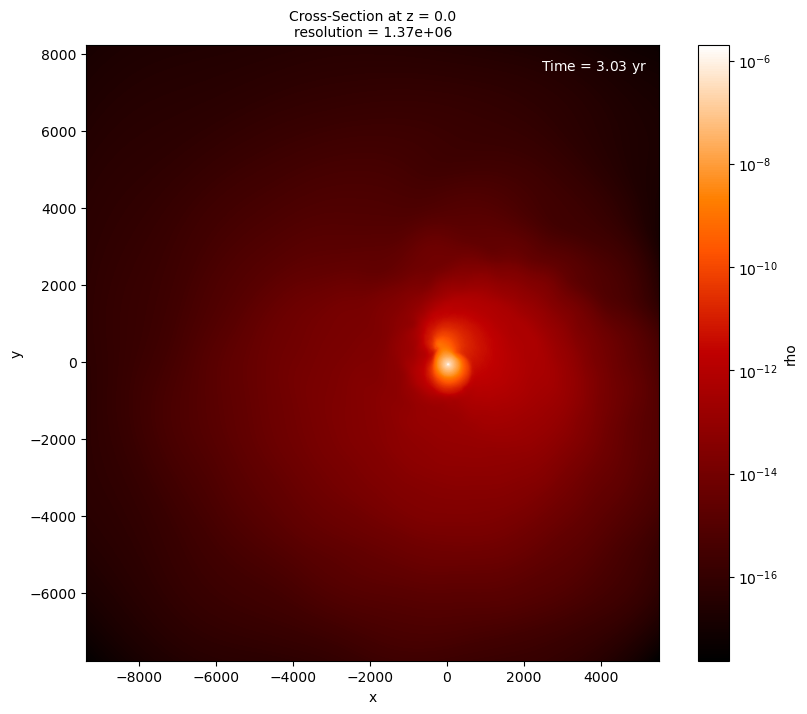

In [22]:
if __name__ == '__main__':
    print(f"Running scipt as {__name__}.\nNote: The following codes are for testing purpose only.\n")
    
    JOB_NAME = "../../photosphere/luis_4md/light"
    use_idealgas_temperature = True
    mu = 2.380981    # mean molecular weight, used if use_idealgas_temperature
    #JOB_NAME = "../../dustystar/clmu_dustybinary/clmu_dustybinary"
    FILE_RANGE = (0, 1200+1, 1200)
    #FILE_RANGE = (0, 1000+1, 1)

    KAPPA_GAS = 1e-4 * (units.cm**2/units.g)    # gas opacity
    BOWEN_KMAX = 15. * (units.cm**2/units.g)    # maximum dust opacity (cm²/g)
    BOWEN_TCOND = 1500. * units.K    # dust condensation temperature (K)
    BOWEN_DELTA = 50. * units.K    # condensation temperature range (K)
    BOWEN_DUST_PARS = {
        'kmax' : BOWEN_KMAX,
        'Tcond': BOWEN_TCOND,
        'delta': BOWEN_DELTA,
        'kappa_gas': KAPPA_GAS,
    }
    
    PLOT_TITLE_SUFFIX = f" with Bowen Dust\n"
    PLOT_TITLE_SUFFIX += f"$k_{{\\rm max}}$ = {BOWEN_KMAX.value} {BOWEN_KMAX.unit.to_string('latex_inline')}; "
    PLOT_TITLE_SUFFIX += f"$T_{{\\rm cond}}$ = {BOWEN_TCOND.value} {BOWEN_TCOND.unit.to_string('latex_inline')}; "
    PLOT_TITLE_SUFFIX += f"$\\delta$ = {BOWEN_DELTA.value} {BOWEN_DELTA.unit.to_string('latex_inline')}; "
    PLOT_TITLE_SUFFIX += f"$\\kappa_{{\\rm gas}}$ = {KAPPA_GAS.value:.1e} {KAPPA_GAS.unit.to_string('latex_inline')}; "
    
    #PLOT_TITLE_SUFFIX = ""

    moviefilenames = {}
    mpdf = MyPhantomDataFrames(print_debug=True)
    mpdf.read(
        JOB_NAME, FILE_RANGE[1]-1,
        calc_params=['T', 'P', 'R1'],
        calc_params_params={'mu': None,},
        print_debug=True,
    )
    fig, ax = mpdf.plot_render()

***  Warning: kappa column exists. We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") However in phantom kappa is often (?) assumed to be in cgs unit. 
    If so, please COVERT KAPPA MANNUALLY into PHANTOM UNITS by using code, such as: 
        mpdf.data['gas']['kappa'] =  mupl.set_as_quantity(mpdf.data['gas']['kappa'], units.cm**2/units.g).to_value(mpdf.units['opacity'])
***  Warning: kappa column exists. We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") However in phantom kappa is often (?) assumed to be in cgs unit. 
    If so, please COVERT KAPPA MANNUALLY into PHANTOM UNITS by using code, such as: 
        mpdf.data['gas']['kappa'] =  mupl.set_as_quantity(mpdf.data['gas']['kappa'], units.cm**2/units.g).to_value(mpdf.units['opacity'])
***  Warning: kappa column exists. We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") However in phantom kappa is often (?) assumed to be in cgs 

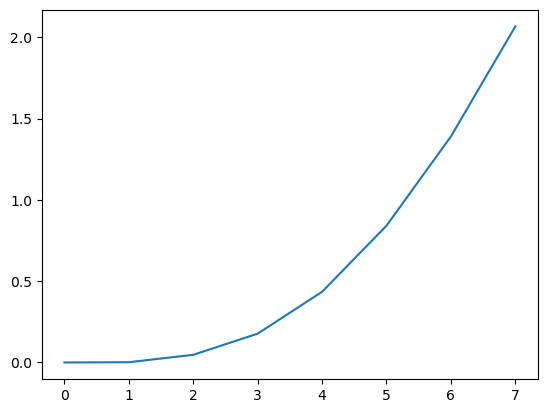

In [20]:
if __name__ == '__main__':
    r_CoMs = []
    times = []
    for i in range(*FILE_RANGE):
        mpdf.read(JOB_NAME, i, reset_xyz_by_CoM=False)
        r_CoMs.append(get_r_from_loc(mpdf.loc_CoM))
        times.append(mpdf.get_time().to_value(units.year))

    plt.plot(times, r_CoMs)

if __name__ == '__main__':
    #print(mpdf.params.keys())
    mpdf.read(JOB_NAME, 1000)
    rendered = 'kappad'
    sdf = mpdf.data['gas']
    sdf['kappad'] = get_opacity_dust_bowen1988(Teq=sdf['Tdust'], kmax=BOWEN_KMAX, Tcond=BOWEN_TCOND, delta=BOWEN_DELTA)
    mpdf.plot_render(
        plot_title_suffix=PLOT_TITLE_SUFFIX,
        rendered=rendered, xlim=(-10000, 10000), ylim=(-10000, 10000),
        norm=mpl.colors.LogNorm(vmin=1e-4, vmax=5, clip=True),
        #norm=mpl.colors.LogNorm(vmin=1e-30, vmax=1e-6, clip=True),
        unit_time_print_utime_too=True,
    )
    print(max(sdf[rendered]))

if __name__ == '__main__':
    rendered='rho'
    moviefilenames[rendered] = plot_mpdf_movies_xsec(
        job_name=JOB_NAME, file_range=FILE_RANGE, plot_title_suffix=PLOT_TITLE_SUFFIX+"\nDensity $\\rho$",
        xyz_axis='xyz', xsec=0.0, rendered=rendered,
        xlim=(-10000, 10000), ylim=(-10000, 10000),
        norm=mpl.colors.LogNorm(vmin=1e-30, vmax=1e-6, clip=True),
        unit_time=units.year, unit_time_print_utime_too=False,
        fps=1,
        debug_verbose=1,
    )

if __name__ == '__main__':
    rendered='kappad'
    moviefilenames[rendered] = plot_mpdf_movies_xsec_opacity_bowendust(
        job_name=JOB_NAME, file_range=FILE_RANGE,
        plot_title_suffix=PLOT_TITLE_SUFFIX+"\nBowen Opacity $\\kappa = \\kappa_{{\\rm d}} + \\kappa_{{\\rm g}}$",
        kmax=BOWEN_KMAX, Tcond=BOWEN_TCOND, delta=BOWEN_DELTA, kappa_gas = KAPPA_GAS,
        xyz_axis='xyz', xsec=0.0, rendered=rendered,
        xlim=(-10000, 10000), ylim=(-10000, 10000),
        norm=mpl.colors.LogNorm(vmin=1e-4, vmax=BOWEN_KMAX.value, clip=True),
        unit_time=units.year, unit_time_print_utime_too=False,
        fps=1,
        debug_verbose=1,
    )

if __name__ == '__main__':
    from moviepy.editor import VideoFileClip
    vid = VideoFileClip(moviefilenames['rho'])
vid.ipython_display()

if __name__ == '__main__':
    from moviepy.editor import VideoFileClip
    vid = VideoFileClip(moviefilenames['kappad'])
vid.ipython_display()

if __name__ == '__main__':
    rendered='rho'
    moviefilenames[rendered] = plot_mpdf_movies_xsec(
        job_name=JOB_NAME, file_range=(0, 200+1, 1), plot_title_suffix=PLOT_TITLE_SUFFIX+"\nDensity $\\rho$",
        fig=None, ax=None,
        xyz_axis='xyz', xsec=0.0, rendered=rendered,
        xlim=(-2000, 2000), ylim=(-2000, 2000),
        norm=mpl.colors.LogNorm(vmin=1e-14, vmax=1e-6, clip=True),
        unit_time=units.year, unit_time_print_utime_too=False,
        fps=20,
        debug_verbose=1,
    )

if __name__ == '__main__':
    from moviepy.editor import VideoFileClip
    vid = VideoFileClip(moviefilenames['rho'])
vid.ipython_display()

## Photosphere temperature profile

    if __name__ == '__main__':
        mpdf.read(
            JOB_NAME, 0000,
            calc_params=['T'],
            print_debug=True,
        )
        use_idealgas_temperature = True
        mu=0.6
        if use_idealgas_temperature:
            mpdf.data['gas']['Tideal'] = \
            (2./3. * mu * (set_as_quantity(mpdf.data['gas']['u'], unit=mpdf.units['specificEnergy']) \
                          ) / CONST_KB_ON_MH).cgs.value
            mpdf.data['gas']['T'] = mpdf.data['gas']['Tideal']
        print(f"\n{mpdf.get_time() = }")

In [23]:
if __name__ == '__main__':
    mpdf.read(
        JOB_NAME, 0000,
        calc_params=['T', 'kappa'],
        calc_params_params={'ieos':10., 'X':0.686, 'overwrite':False, 'kappa_translate_from_cgs_units':True},
        print_debug=True,
    )
    use_idealgas_temperature = False
    #mu=0.6
    if use_idealgas_temperature:
        mpdf.data['gas']['Tideal'] = \
        (2./3. * mu * (set_as_quantity(mpdf.data['gas']['u'], unit=mpdf.units['specificEnergy']) \
                      ) / CONST_KB_ON_MH).cgs.value
        mpdf.data['gas']['T'] = mpdf.data['gas']['Tideal']
    print(f"\n{mpdf.get_time() = }")


Reading filename='../../photosphere/luis_4md/binary_00000'
udist = 1.00036 solRad
umass = 1.00035 solMass
utime = 1.00053 unit_time
self.time = 0.0
self.gamma = 1.6666666666666667
self.ieos = 10
self.total_mass = 4.332528908955826
Center of mass location: self.loc_CoM = array([-2.20418480e-12,  6.61602903e-15,  3.42743236e-15])
    Note: Using ieos= 10.0 for temperature calc.
get_temp_from_u():  max rtol = 5.5060986326146395e-09 after 4 iters.
get_temp_from_u():  max rtol = 6.393090849628035e-14 after 4 iters.
get_temp_from_u():  Using average temp for 0 out of 1372088 particles.
                    0 out of which are contradicting each other (T > 10000K if mu=0.6, T < 6000K if mu=2.38)

mpdf.get_time() = <Quantity 0. yr>


In [24]:
if __name__ == '__main__':
    rat = mpdf.data['gas']['T'] / mpdf.data['gas']['Tideal']
    print(np.average(rat), "+/-", np.std(rat))

KeyError: 'Tideal'

In [26]:
if __name__ == '__main__':
    PHOTOSPHERE_TAU = 1.
    photosphere_tau = PHOTOSPHERE_TAU
    
    
    star1_x = mpdf.data['sink'].x[0]
    star1_y = mpdf.data['sink'].y[0]
    star1_z = mpdf.data['sink'].z[0]
    ray = np.array([
        [star1_x, star1_y, star1_z],
        [star1_x, star1_y+100., star1_z+100.],
    ])
    ray_unit_vec = ray[1, :] - ray[0, :]
    ray_unit_vec = ray_unit_vec / np.sum(ray_unit_vec**2)**0.5
    
    
    # optimization- first select only the particles affecting the ray
    #  because interpolation of m points with N particles scales with O(N*m),
    #  reducing N can speed up calc significantly
    sdf = mpdf.data['gas']
    kernel_radius = sdf.kernel.get_radius()
    hs = np.array(sdf['h'])
    pts = np.array(sdf[['x', 'y', 'z']])    # (npart, 3)-shaped array
    pts_on_ray = get_closest_pt_on_line(pts, ray)
    sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
    print(f"{np.count_nonzero(sdf_selected_indices)} particles are close enough to the ray to have effects.")    # debug
    sdf = sdf.iloc[sdf_selected_indices]
    
    
    # get optical depth
    #sdf['kappa'] = (0.35 * (units.cm**2/units.g)).to_value(mpdf.units['opacity'])
    sdf['kappa'] = get_opacity_dust_bowen1988(Teq=sdf['T'], **BOWEN_DUST_PARS).to_value(mpdf.units['opacity'])
    sdf['flux']  = mpdf.const['sigma_sb'] * sdf['T']**4
    #print(f"\n{sdf = }\n")
    print(f"\n{ray = }\n")
    pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf=sdf, ray=ray)
    pts_order_nonzero = np.where(dtaus[pts_order])[0]
    print(f"\n{pts_order_nonzero.size = }\n")
    pts_on_ray_ordered = pts_on_ray[pts_order]
    dist_to_ray0_ordered = np.sum((pts_on_ray_ordered - ray[0]) * ray_unit_vec, axis=-1)
    taus_ordered = np.cumsum(dtaus[pts_order])
    
    
    # get photosphere
    photosphere_loc_index = np.searchsorted(taus_ordered, photosphere_tau) - 1
    photosphere_found = photosphere_loc_index <= len(sdf) - 2
    if photosphere_found:
        if photosphere_loc_index == -1:
            # if first particle blocks everything: estimate it to be where that particle is
            photosphere_loc_index = 0
            photosphere_loc = pts_on_ray_ordered[0]
        else:
            # intepolate to find loc
            photosphere_taus = taus_ordered[photosphere_loc_index : photosphere_loc_index+2]
            photosphere_dtau = photosphere_taus[1] - photosphere_taus[0]
            photosphere_dtau0_frac = (photosphere_taus[1] - photosphere_tau) / photosphere_dtau
            photosphere_loc = \
                pts_on_ray_ordered[photosphere_loc_index] * photosphere_dtau0_frac + \
                pts_on_ray_ordered[photosphere_loc_index+1] * (1 - photosphere_dtau0_frac)
        photosphere_dist_to_ray0 = np.sum((photosphere_loc - ray[0]) * ray_unit_vec, axis=-1)
        print(    # debug
            f"{photosphere_loc = }\n{photosphere_dist_to_ray0 = }\n",
            f"{photosphere_taus = }\n",
            f"{pts_on_ray_ordered[photosphere_loc_index:photosphere_loc_index+2] = }",
        )
    else:
        print(f"*    Warning: Photosphere not found ({photosphere_loc_index=}; {max(taus_ordered)=})")

3873 particles are close enough to the ray to have effects.

ray = array([[-8.82159543e+01, -1.82796033e-03, -1.03191347e-03],
       [-8.82159543e+01,  9.99981720e+01,  9.99989681e+01]])


pts_order_nonzero.size = 3873

photosphere_loc = array([-88.21595428, 218.62965637, 218.63045242])
photosphere_dist_to_ray0 = 309.1916103037488
 photosphere_taus = array([0.99329922, 1.18218821])
 pts_on_ray_ordered[photosphere_loc_index:photosphere_loc_index+2] = array([[-88.21595428, 218.63891687, 218.63971292],
       [-88.21595428, 218.37787156, 218.37866761]])


    # debug
    sdf = mpdf.data['gas']
    T = np.array(sdf['T'])
    locs = np.array(sdf[['x', 'y', 'z']])
    locs_1 = locs[:1000]
    T_1 = T[:1000]

    # debug
    %%timeit
    T_interp = get_sph_interp(sdf=sdf, target='T', locs=locs_1)

    # debug
    X = (T_1 - T_interp)/T_1
    X[X<0]

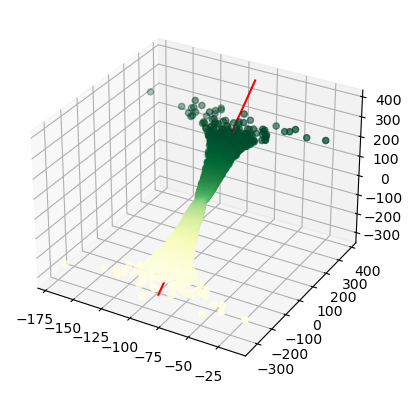

In [49]:
if __name__ == '__main__':
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ray_plot = ray.copy()
    ray_plot[0, :] -= ray_unit_vec*400.
    ray_plot[1, :] += ray_unit_vec*400.
    pts = np.array(sdf[['x', 'y', 'z']])
    x = pts[pts_order, 0][pts_order_nonzero]
    y = pts[pts_order, 1][pts_order_nonzero]
    z = pts[pts_order, 2][pts_order_nonzero]
    c = -np.arange(x.size)/x.size
    ax.scatter3D(x, y, z, c=c, cmap=mpl.colormaps['YlGn']); #, depthshade=False
    ax.plot3D(ray_plot[:, 0], ray_plot[:, 1], ray_plot[:, 2], color = 'red')
    fig.show()

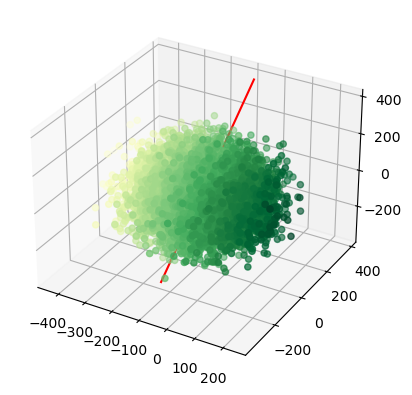

In [79]:
if __name__ == '__main__':
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ray_plot = ray.copy()
    ray_plot[0, :] -= ray_unit_vec*400.
    ray_plot[1, :] += ray_unit_vec*400.
    pts = np.array(mpdf.data['gas'][['x', 'y', 'z']])
    ind = np.random.choice(np.arange(len(pts)), 10000)
    pts = pts[ind]
    x = pts[:, 0]#[pts_order_nonzero]
    y = pts[:, 1]#[pts_order_nonzero]
    z = pts[:, 2]#[pts_order_nonzero]
    c = x#-np.arange(x.size)/x.size
    ax.scatter3D(x, y, z, c=c, cmap=mpl.colormaps['YlGn']); #, depthshade=False
    ax.plot3D(ray_plot[:, 0], ray_plot[:, 1], ray_plot[:, 2], color = 'red')
    fig.show()

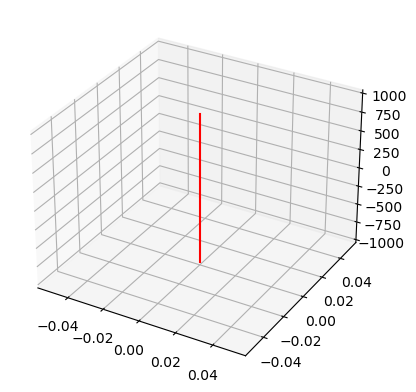

In [23]:
if __name__ == '__main__':
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    #pts = np.array(sdf[['x', 'y', 'z']])
    #x = pts[pts_order, 0][pts_order_nonzero]
    #y = pts[pts_order, 1][pts_order_nonzero]
    #z = pts[pts_order, 2][pts_order_nonzero]
    #c = -np.arange(x.size)/x.size
    #ax.scatter3D(x, y, z, c=c, cmap=mpl.colormaps['YlGn']); #, depthshade=False
    ax.plot3D([0., 0.], [0., 0.], [-1000., 1000.], color = 'red')
    fig.show()

In [27]:
if __name__ == '__main__':
    # plot settings
    xlim = (10, 100000)
    sample_size_T = 1000
    
    # calc temperature profiles
    dist_to_ray0_samples = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), sample_size_T)
    pts_on_ray_samples = ray[0] + dist_to_ray0_samples.reshape((-1, 1)) * ray_unit_vec
    T_samples = get_sph_interp(sdf, 'T', pts_on_ray_samples)
    rho_samples = get_sph_interp(sdf, 'rho', pts_on_ray_samples)
    
    # getting photosphere pars
    photosphere = {}
    if photosphere_found:
        # get lum & other photosphere quantities
        photosphere['loc'] = photosphere_loc
        photosphere['R1'] = photosphere_dist_to_ray0
        for col in ['T', 'rho', 'h']:
            photosphere[col] = get_sph_interp(sdf, col, photosphere_loc)
        area_eff_quantity = 4 * pi * (photosphere['R1'] * mpdf.units['dist'])**2
        lum_eff_quantity = (const.sigma_sb * (photosphere['T'] * units.K)**4 * area_eff_quantity).to(units.solLum)
        
        # get lum & T errors
        dist_to_ray0_samples_ph = np.logspace(
            np.log10(photosphere['R1'] - photosphere['h']), np.log10(photosphere['R1'] + photosphere['h']),
            sample_size_T,
        )
        pts_on_ray_samples_ph = ray[0] + dist_to_ray0_samples_ph.reshape((-1, 1)) * ray_unit_vec
        T_samples_ph = get_sph_interp(sdf, 'T', pts_on_ray_samples_ph)
        area_eff_quantities_ph = 4 * pi * (dist_to_ray0_samples_ph * mpdf.units['dist'])**2
        lum_eff_quantities_ph = (const.sigma_sb * (T_samples_ph * units.K)**4 * area_eff_quantities_ph).to(units.solLum)
        photosphere['T_m'] = min(T_samples_ph) - photosphere['T']
        photosphere['T_p'] = max(T_samples_ph) - photosphere['T']
        lum_eff_quantity_m = min(lum_eff_quantities_ph) - lum_eff_quantity
        lum_eff_quantity_p = max(lum_eff_quantities_ph) - lum_eff_quantity
        print(f"{photosphere = }\n{area_eff_quantity = }\n{lum_eff_quantity = :.1f}")
        print(f"{lum_eff_quantity_m = :+.1f}\n{lum_eff_quantity_p = :+.1f}")
        
    # getting flux ( ***EXPERIMENTAL*** )
    flux = 0
    fluxes = []
    fopacities = np.exp(-dtaus)
    for pts_i in np.flip(pts_order):
        flux = flux * fopacities[pts_i] + sdf['flux'].iloc[pts_i] * (1 - fopacities[pts_i])
        fluxes.append(flux)
    fluxes = np.array(fluxes)
    flux_quantity = flux * mpdf.units['flux']
    if photosphere_found:
        #Leff_flux_quantity = (flux_quantity * 4 * pi * (dist_to_ray0_ordered[0] * mpdf.units['dist'])**2).to(units.solLum)
        Leff_flux_quantity = (flux_quantity * area_eff_quantity).to(units.solLum)
        print(f"{flux_quantity = :.1e}\n{Leff_flux_quantity = :.1e}")
        


photosphere = {'loc': array([-1.43124709e+02, -2.56225791e-03,  2.32448106e+02]), 'R1': 232.4500335656414, 'T': 6692.0479667653735, 'rho': 1.3007203442789949e-09, 'h': 10.74947673261009, 'T_m': -1238.346260861781, 'T_p': 1464.1926512130485}
area_eff_quantity = <Quantity 678998.93091563 udist2>
lum_eff_quantity = 97701.5 solLum
lum_eff_quantity_m = -50528.1 solLum
lum_eff_quantity_p = +98408.4 solLum
flux_quantity = 3.2e-13 umass / utime3
Leff_flux_quantity = 1.4e+05 solLum


#### show closest particles to the photosphere-ray interception point

x = get_sph_close_pts_indices(photosphere_loc, sdf=sdf)
print(f"{np.count_nonzero(x) = }")
sdf_relevant = sdf.iloc[x][['x', 'y', 'z', 'm', 'h', 'kappa', 'rho', 'T']]
pts = np.array(sdf_relevant[['x', 'y', 'z']])
hs  = np.array(sdf_relevant['h'])
qs = np.sum((pts - photosphere_loc)**2, axis=-1)**0.5 / hs
sdf_relevant['q'] = qs
print(f"{min(sdf_relevant['h']) = } , {max(sdf_relevant['h']) = }")
pts = np.array(sdf_relevant[['x', 'y', 'z']])
qs = np.sum((pts - photosphere_loc)**2, axis=-1)**0.5

sdf_relevant

#### verifying kernel normalization is correctly 1.

x = np.linspace(-2., 2., 100)
y = np.linspace(-2., 2., 100)
z = np.linspace(-2., 2., 100)
xv, yv, zv = np.meshgrid(x, y, z)
rv = (xv**2 + yv**2 + zv**2)**0.5
wv = kernel.w(rv, 3)
np.trapz(np.trapz(np.trapz(wv, x), y), z)

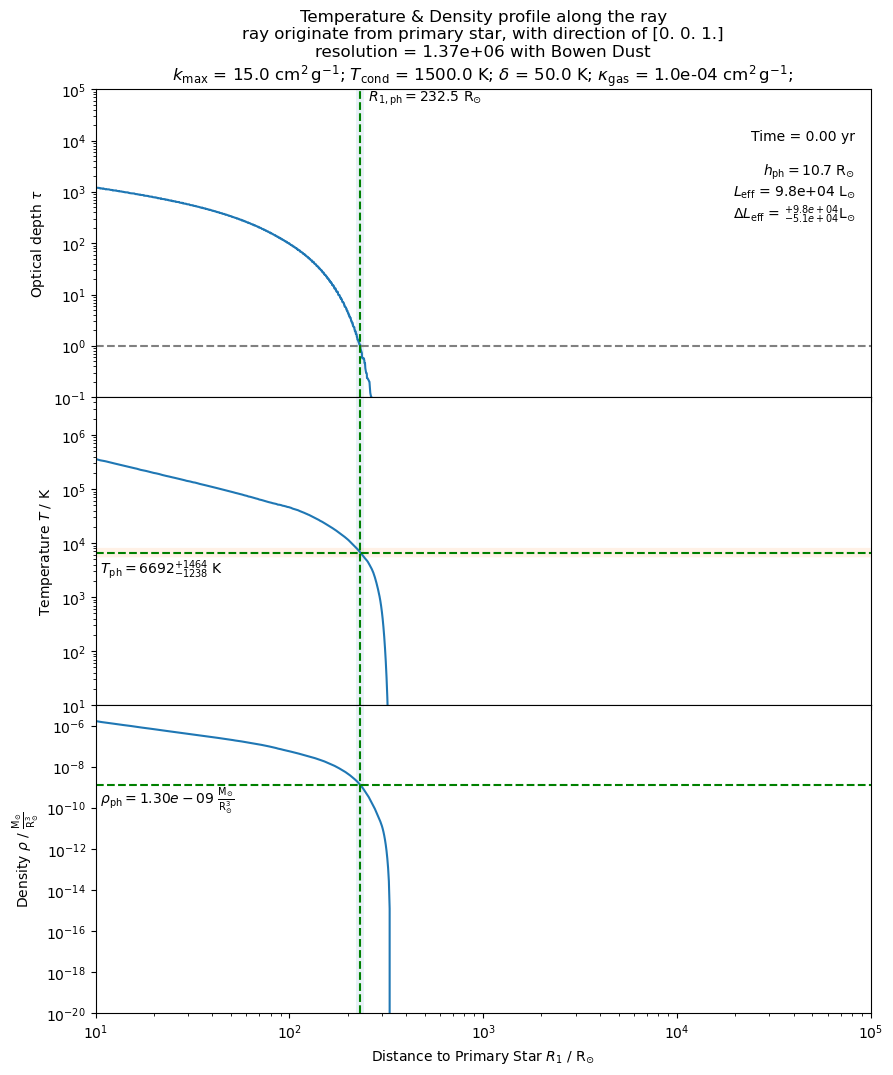

In [37]:
if __name__ == '__main__':
    # plotting
    ylim_tau = (1e-1, 1e5)
    ylim_T = (1e1, 5e6)
    ylim_rho = (1e-20, 1e-5)
    plot_title_suffix=PLOT_TITLE_SUFFIX
    #plot_title_suffix=''

    
    unit_dist_text = units.solRad.to_string('latex')
    unit_temp_text = units.K.to_string('latex')
    #unit_rho_text  = mpdf.units['density'].cgs.to_string('latex')
    unit_rho_text  = (units.solMass/units.solRad**3).to_string('latex')
    
    # plot1 - optical depth
    ylim = ylim_tau
    fig, axes = plt.subplots(3, figsize=(10, 12), sharex=True)
    #fig.tight_layout()
    fig.subplots_adjust(hspace=0.0)
    ax = axes[0]
    ax.semilogy(dist_to_ray0_ordered, taus_ordered)
    ax.set_ylim(ylim)
    ax.set_ylabel("Optical depth $\\tau$")
    ax.tick_params(which='both', labelbottom=False)
    ax.axhline(1., color='grey', linestyle='dashed')
    if photosphere_found:
        ax.axvline(photosphere_dist_to_ray0, color='green', linestyle='dashed')
        ax.fill_betweenx(ylim, photosphere['R1'] + photosphere['h'], photosphere['R1'] - photosphere['h'], alpha=0.1)
        ax.text(photosphere['R1'] + photosphere['h'], ylim[1],
                #f" Photosphere distance to primary star:\n" + \
                f" $R_{{1, \\rm ph}} = {photosphere['R1']:.1f} $ {unit_dist_text}", va='top')
    ax.text(
        0.98, 0.87, f"Time = {mpdf.get_time(unit=units.year):.2f}\n" + \
        #"\nSmoothing Length\nat the photosphere:\n" + \
        f"\n$h_{{\\rm ph}} = {photosphere['h']:.1f} $ {unit_dist_text}\n" + \
        #"\nEffective Luminosity\nfrom $R_{{1, \\rm ph}}$ and $T_{{\\rm ph}}$:\n" + \
        f"$L_{{\\rm eff}}$ = {lum_eff_quantity.value:.1e} {lum_eff_quantity.unit.to_string('latex')}\n" + \
        f"$\\Delta L_{{\\rm eff}}$ = $^{{{lum_eff_quantity_p.value:+.1e}}}_{{{lum_eff_quantity_m.value:+.1e}}}$" + \
        f"{lum_eff_quantity.unit.to_string('latex')}\n",
        color = "black", ha = 'right', va = 'top',
        transform=ax.transAxes,
    )
    ax.set_title(
        "Temperature & Density profile along the ray\n" + \
        f"ray originate from primary star, with direction of {ray_unit_vec}\n" + \
        f"resolution = {mpdf.params['nparttot']:.2e}{plot_title_suffix}",
    )
    
    # plot2 - Temperature profile
    ax = axes[1]
    ylim = ylim_T
    ax.loglog(dist_to_ray0_samples, T_samples)
    ax.set_ylim(ylim)
    ax.set_ylabel(f"Temperature $T$ / {unit_temp_text}")
    #ax.set_yticks(ax.get_yticks()[:-2])    # remove top-most one tick to avoid overlap
    if photosphere_found:
        ax.axvline(photosphere_dist_to_ray0, color='green', linestyle='dashed')
        ax.axhline(photosphere['T'], color='green', linestyle='dashed')
        ax.fill_betweenx(ylim, photosphere['R1'] + photosphere['h'], photosphere['R1'] - photosphere['h'], alpha=0.1)
        ax.fill_between(
            dist_to_ray0_samples,
            y1=photosphere['T'] + photosphere['T_m'],
            y2=photosphere['T'] + photosphere['T_p'],
            alpha=0.1,# color='red',
        )
        ax.text(xlim[0], photosphere['T'] + photosphere['T_m'],
                #f" Photosphere temperature:\n" + \
                f" $T_{{\\rm ph}} = {photosphere['T']:.0f}" + \
                f"^{{{photosphere['T_p']:+.0f}}}_{{{photosphere['T_m']:+.0f}}} $" + \
                f" {unit_temp_text}",
                va='top')
    #ax.set_xlim(xlim)
    #ax.set_xlabel(f"Distance to Primary Star $R_1$ on ray / {unit_dist_text}")
    
    
    # plot3 - Density profile
    ax = axes[2]
    ylim = ylim_rho
    ax.loglog(dist_to_ray0_samples, rho_samples)
    ax.set_ylim(ylim)
    ax.set_ylabel(f"Density $\\rho$ / {unit_rho_text}")
    #ax.set_yticks(ax.get_yticks()[:-2])    # remove top-most one tick to avoid overlap
    if photosphere_found:
        ax.axvline(photosphere_dist_to_ray0, color='green', linestyle='dashed')
        ax.axhline(photosphere['rho'], color='green', linestyle='dashed')
        ax.fill_betweenx(ylim, photosphere['R1'] + photosphere['h'], photosphere['R1'] - photosphere['h'], alpha=0.1)
        ax.text(xlim[0], photosphere['rho'],
                #f" Photosphere density:\n" + \
                f" $\\rho_{{\\rm ph}} = {photosphere['rho']:.2e} $ {unit_rho_text}", va='top')
    ax.set_xlim(xlim)
    ax.set_xlabel(f"Distance to Primary Star $R_1$ / {unit_dist_text}")
    
    fig.show()

In [39]:
# Making a movie of photosphere temperature profile
# *   Warning: Assuming Bowen dust opacity - see BOWEN_DUST_PARS

def plot_mpdf_movies_single_ray_trace_profiles__TMP_FUNC_IGNORE_ME(
    job_name, file_range, plot_title_suffix,
    ray_dir_vec=np.array([0., 0., 100.]),
    use_idealgas_temperature=True,
    mu=2.380981,    # mean molecular weight, used if use_idealgas_temperature
    photosphere_tau=1.,
    ieos=10,
    X=0.686,
    fps=1,
):
    """Plot Movies of single ray tracing (from primary star) & temperature & density profiles.
    
    *** EXPERIMENTAL - USE WITH CAUTION ***
    
    """
    # settings
    #use_idealgas_temperature = True
    #mu = 2.380981    # mean molecular weight, used if use_idealgas_temperature
    xlim = (10., 100000.)
    ylim_tau = (1e-1, 1e5)
    ylim_T = (1e1, 5e6)
    ylim_rho = (1e-20, 1e-5)
    sample_size_T = 1000
    unit_dist_text = units.solRad.to_string('latex')
    unit_temp_text = units.K.to_string('latex')
    #unit_rho_text  = mpdf.units['density'].cgs.to_string('latex')
    unit_rho_text  = (units.solMass/units.solRad**3).to_string('latex')
    
    outfilenames = []
    times = []
    photospheres = []
    lum_effs = []
    mpdf = MyPhantomDataFrames()
    # read files
    for i in range(*FILE_RANGE):
        if use_idealgas_temperature: calc_params=[]
        else: calc_params=['T', 'kappa']
        mpdf.read(
            job_name, i,
            calc_params=calc_params,
            calc_params_params={'ieos': ieos, 'X':X, 'overwrite':False, 'kappa_translate_from_cgs_units':True},
        )
        if use_idealgas_temperature:
            mpdf.data['gas']['T'] = \
            (2./3. * mu * (set_as_quantity(mpdf.data['gas']['u'], unit=mpdf.units['specificEnergy']) \
                          ) / CONST_KB_ON_MH).cgs.value
        filename = mpdf.get_filename()
        print(f"\n\nWorking on: {filename}\n")

        star1_x = mpdf.data['sink'].x[0]
        star1_y = mpdf.data['sink'].y[0]
        star1_z = mpdf.data['sink'].z[0]
        ray = np.array([
            [star1_x, star1_y, star1_z],
            [star1_x, star1_y, star1_z],
        ])
        ray[1] += ray_dir_vec
        ray_unit_vec = ray[1, :] - ray[0, :]
        ray_unit_vec = ray_unit_vec / np.sum(ray_unit_vec**2)**0.5


        # optimization- first select only the particles affecting the ray
        #  because interpolation of m points with N particles scales with O(N*m),
        #  reducing N can speed up calc significantly
        sdf = mpdf.data['gas']
        kernel_radius = sdf.kernel.get_radius()
        hs = np.array(sdf['h'])
        pts = np.array(sdf[['x', 'y', 'z']])    # (npart, 3)-shaped array
        pts_on_ray = get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        print(f"{np.count_nonzero(sdf_selected_indices)} particles are close enough to the ray to have effects.")    # debug
        sdf = sdf.iloc[sdf_selected_indices]
    
        # get optical depth
        #sdf['kappa'] = (0.35 * (units.cm**2/units.g)).to_value(mpdf.units['opacity'])
        #sdf['kappa'] = get_opacity_dust_bowen1988(Teq=sdf['T'], **BOWEN_DUST_PARS).to_value(mpdf.units['opacity'])
        #print(f"\n{sdf = }\n")
        print(f"{ray = }\n")
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf=sdf, ray = ray)
        pts_order_nonzero = np.where(dtaus[pts_order])[0]
        print(f"{pts_order_nonzero.size = }\n")
        pts_on_ray_ordered = pts_on_ray[pts_order]
        dist_to_ray0_ordered = np.sum((pts_on_ray_ordered - ray[0]) * ray_unit_vec, axis=-1)
        taus_ordered = np.cumsum(dtaus[pts_order])


        # get photosphere
        photosphere_loc_index = np.searchsorted(taus_ordered, photosphere_tau) - 1
        photosphere_found = photosphere_loc_index <= len(sdf) - 2
        if photosphere_found:
            if photosphere_loc_index == -1:
                # if first particle blocks everything: estimate it to be where that particle is
                photosphere_loc_index = 0
                photosphere_loc = pts_on_ray_ordered[0]
            else:
                # intepolate to find loc
                photosphere_taus = taus_ordered[photosphere_loc_index : photosphere_loc_index+2]
                photosphere_dtau = photosphere_taus[1] - photosphere_taus[0]
                photosphere_dtau0_frac = (photosphere_taus[1] - photosphere_tau) / photosphere_dtau
                photosphere_loc = \
                    pts_on_ray_ordered[photosphere_loc_index] * photosphere_dtau0_frac + \
                    pts_on_ray_ordered[photosphere_loc_index+1] * (1 - photosphere_dtau0_frac)
            photosphere_dist_to_ray0 = np.sum((photosphere_loc - ray[0]) * ray_unit_vec, axis=-1)
        else:
            print(f"*    Warning: Photosphere not found ({max(taus_ordered)=})")


        # calc temperature profiles
        dist_to_ray0_samples = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), sample_size_T)
        pts_on_ray_samples = ray[0] + dist_to_ray0_samples.reshape((-1, 1)) * ray_unit_vec
        T_samples = get_sph_interp(sdf, 'T', pts_on_ray_samples)
        rho_samples = get_sph_interp(sdf, 'rho', pts_on_ray_samples)
        photosphere = {}
        if photosphere_found:
            # get lum & other photosphere quantities
            photosphere['loc'] = photosphere_loc
            photosphere['R1'] = photosphere_dist_to_ray0
            for col in ['T', 'rho', 'h']:
                photosphere[col] = get_sph_interp(sdf, col, photosphere_loc)
            area_eff_quantity = 4 * pi * (photosphere['R1'] * mpdf.units['dist'])**2
            lum_eff_quantity = (const.sigma_sb * (photosphere['T'] * units.K)**4 * area_eff_quantity).to(units.solLum)

            # get lum & T errors
            dist_to_ray0_samples_ph = np.logspace(
                np.log10(photosphere['R1'] - photosphere['h']), np.log10(photosphere['R1'] + photosphere['h']),
                sample_size_T,
            )
            pts_on_ray_samples_ph = ray[0] + dist_to_ray0_samples_ph.reshape((-1, 1)) * ray_unit_vec
            T_samples_ph = get_sph_interp(sdf, 'T', pts_on_ray_samples_ph)
            area_eff_quantities_ph = 4 * pi * (dist_to_ray0_samples_ph * mpdf.units['dist'])**2
            lum_eff_quantities_ph = (const.sigma_sb * (T_samples_ph * units.K)**4 * area_eff_quantities_ph).to(units.solLum)
            photosphere['T_m'] = min(T_samples_ph) - photosphere['T']
            photosphere['T_p'] = max(T_samples_ph) - photosphere['T']
            lum_eff_quantity_m = min(lum_eff_quantities_ph) - lum_eff_quantity
            lum_eff_quantity_p = max(lum_eff_quantities_ph) - lum_eff_quantity

            
        times.append(mpdf.get_time().to_value(units.year))
        photospheres.append(photosphere)
        lum_effs.append([
            lum_eff_quantity.to_value(units.solLum),
            (lum_eff_quantity + lum_eff_quantity_m).to_value(units.solLum),
            (lum_eff_quantity + lum_eff_quantity_p).to_value(units.solLum),
        ])

        
        # plotting

        # plot1 - optical depth
        ylim = ylim_tau
        fig, axes = plt.subplots(3, figsize=(10, 12), sharex=True)
        #fig.tight_layout()
        fig.subplots_adjust(hspace=0.0)
        ax = axes[0]
        ax.semilogy(dist_to_ray0_ordered, taus_ordered)
        ax.set_ylim(ylim)
        ax.set_ylabel("Optical depth $\\tau$")
        ax.tick_params(which='both', labelbottom=False)
        ax.axhline(1., color='grey', linestyle='dashed')
        if photosphere_found:
            ax.axvline(photosphere_dist_to_ray0, color='green', linestyle='dashed')
            ax.fill_betweenx(ylim, photosphere['R1'] + photosphere['h'], photosphere['R1'] - photosphere['h'], alpha=0.1)
            ax.text(photosphere['R1'] + photosphere['h'], ylim[1],
                    #f" Photosphere distance to primary star:\n" + \
                    f" $R_{{1, \\rm ph}} = {photosphere['R1']:.1f} $ {unit_dist_text}", va='top')
        ax.text(
            0.98, 0.87, f"Time = {mpdf.get_time(unit=units.year):.2f}\n" + \
            #"\nSmoothing Length\nat the photosphere:\n" + \
            f"\n$h_{{\\rm ph}} = {photosphere['h']:.1f} $ {unit_dist_text}\n" + \
            #"\nEffective Luminosity\nfrom $R_{{1, \\rm ph}}$ and $T_{{\\rm ph}}$:\n" + \
            f"$L_{{\\rm eff}}$ = {lum_eff_quantity.value:.1e} {lum_eff_quantity.unit.to_string('latex')}\n" + \
            f"$\\Delta L_{{\\rm eff}}$ = $^{{{lum_eff_quantity_p.value:+.1e}}}_{{{lum_eff_quantity_m.value:+.1e}}}$" + \
            f"{lum_eff_quantity.unit.to_string('latex')}\n",
            color = "black", ha = 'right', va = 'top',
            transform=ax.transAxes,
        )
        ax.set_title(
            "Temperature & Density profile along the ray\n" + \
            f"ray originated from primary star, with direction of {ray_unit_vec}\n" + \
            f"resolution = {mpdf.params['nparttot']:.2e}{plot_title_suffix}",
        )

        # plot2 - Temperature profile
        ax = axes[1]
        ylim = ylim_T
        ax.loglog(dist_to_ray0_samples, T_samples)
        ax.set_ylim(ylim)
        ax.set_ylabel(f"Temperature $T$ / {unit_temp_text}")
        #ax.set_yticks(ax.get_yticks()[:-2])    # remove top-most one tick to avoid overlap
        if photosphere_found:
            ax.axvline(photosphere_dist_to_ray0, color='green', linestyle='dashed')
            ax.axhline(photosphere['T'], color='green', linestyle='dashed')
            ax.fill_betweenx(ylim, photosphere['R1'] + photosphere['h'], photosphere['R1'] - photosphere['h'], alpha=0.1)
            ax.fill_between(
                dist_to_ray0_samples,
                y1=photosphere['T'] + photosphere['T_m'],
                y2=photosphere['T'] + photosphere['T_p'],
                alpha=0.1,# color='red',
            )
            ax.text(xlim[0], photosphere['T'] + photosphere['T_m'],
                    #f" Photosphere temperature:\n" + \
                    f" $T_{{\\rm ph}} = {photosphere['T']:.0f}" + \
                    f"^{{{photosphere['T_p']:+.0f}}}_{{{photosphere['T_m']:+.0f}}} $" + \
                    f" {unit_temp_text}",
                    va='top')
        #ax.set_xlim(xlim)
        #ax.set_xlabel(f"Distance to Primary Star $R_1$ on ray / {unit_dist_text}")


        # plot3 - Density profile
        ax = axes[2]
        ylim = ylim_rho
        ax.loglog(dist_to_ray0_samples, rho_samples)
        ax.set_ylim(ylim)
        ax.set_ylabel(f"Density $\\rho$ / {unit_rho_text}")
        #ax.set_yticks(ax.get_yticks()[:-2])    # remove top-most one tick to avoid overlap
        if photosphere_found:
            ax.axvline(photosphere_dist_to_ray0, color='green', linestyle='dashed')
            ax.axhline(photosphere['rho'], color='green', linestyle='dashed')
            ax.fill_betweenx(ylim, photosphere['R1'] + photosphere['h'], photosphere['R1'] - photosphere['h'], alpha=0.1)
            ax.text(xlim[0], photosphere['rho'],
                    #f" Photosphere density:\n" + \
                    f" $\\rho_{{\\rm ph}} = {photosphere['rho']:.2e} $ {unit_rho_text}", va='top')
        ax.set_xlim(xlim)
        ax.set_xlabel(f"Distance to Primary Star $R_1$ / {unit_dist_text}")
        
        
        # saving
        outfilename_vectxt = f"R1-x{ray_unit_vec[0]:.1f}y{ray_unit_vec[1]:.1f}z{ray_unit_vec[2]:.1f}"
        outfilename = f"{filename}__photosphere-tau+T+rho-profile__{outfilename_vectxt}.png"
        fig.savefig(outfilename)
        
        outfilenames.append(outfilename)
        plt.close(fig)
        

    # Make movie
    with ImageSequenceClip(outfilenames+outfilenames[0:1]*4, fps=fps) as vid:
        moviefilename = f'{job_name}__photosphere-tau+T+rho-profile__{outfilename_vectxt}__movie.mp4'
        vid.write_videofile(moviefilename)
    
    times = times * units.year
    lum_effs = lum_effs*units.solLum
    
    return moviefilename, times, photospheres, lum_effs


ray_dir_vec = array([  0.,   0., 100.])



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_00000

2017 particles are close enough to the ray to have effects.
ray = array([[-1.43128431e+02, -1.26617886e-02,  6.00040702e-04],
       [-1.43128431e+02, -1.26617886e-02,  1.00000600e+02]])

pts_order_nonzero.size = 2017



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_01000

2000 particles are close enough to the ray to have effects.
ray = array([[-1.34895097e+02,  4.43006439e+01,  3.18833110e-02],
       [-1.34895097e+02,  4.43006439e+01,  1.00031883e+02]])

pts_order_nonzero.size = 2000



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_02000

2040 particles are close enough to the ray to have effects.
ray = array([[-1.22324042e+02,  6.64324403e+01, -1.16433903e-01],
       [-1.22324042e+02,  6.64324403e+01,  9.98835661e+01]])

pts_order_nonzero.size = 2040



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_03000

2136 

Moviepy - Done !
Moviepy - video ready ../../dustystar/test_miguel/bowendust_res-1e5/binary__photosphere-T+rho-profile_Bowen-dust-opacity__R1-x0.0y0.0z1.0__movie.mp4

ray_dir_vec = array([100.,   0., 100.])



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_00000

2019 particles are close enough to the ray to have effects.
ray = array([[-1.43128431e+02, -1.26617886e-02,  6.00040702e-04],
       [-4.31284305e+01, -1.26617886e-02,  1.00000600e+02]])

pts_order_nonzero.size = 2019



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_01000

2046 particles are close enough to the ray to have effects.
ray = array([[-1.34895097e+02,  4.43006439e+01,  3.18833110e-02],
       [-3.48950974e+01,  4.43006439e+01,  1.00031883e+02]])

pts_order_nonzero.size = 2046



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_02000

2092 particles are close enough to the ray to have effects.
ray = array([[-1.22324042e+02,  6.64324403e+01, -1.16433903e-01],
      

Moviepy - Done !
Moviepy - video ready ../../dustystar/test_miguel/bowendust_res-1e5/binary__photosphere-T+rho-profile_Bowen-dust-opacity__R1-x0.7y0.0z0.7__movie.mp4

ray_dir_vec = array([100.,   0.,   0.])



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_00000

1978 particles are close enough to the ray to have effects.
ray = array([[-1.43128431e+02, -1.26617886e-02,  6.00040702e-04],
       [-4.31284305e+01, -1.26617886e-02,  6.00040702e-04]])

pts_order_nonzero.size = 1978



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_01000

2107 particles are close enough to the ray to have effects.
ray = array([[-1.34895097e+02,  4.43006439e+01,  3.18833110e-02],
       [-3.48950974e+01,  4.43006439e+01,  3.18833110e-02]])

pts_order_nonzero.size = 2107



Working on: ../../dustystar/test_miguel/bowendust_res-1e5/binary_02000

2187 particles are close enough to the ray to have effects.
ray = array([[-1.22324042e+02,  6.64324403e+01, -1.16433903e-01],
      

Moviepy - Done !
Moviepy - video ready ../../dustystar/test_miguel/bowendust_res-1e5/binary__photosphere-T+rho-profile_Bowen-dust-opacity__R1-x1.0y0.0z0.0__movie.mp4


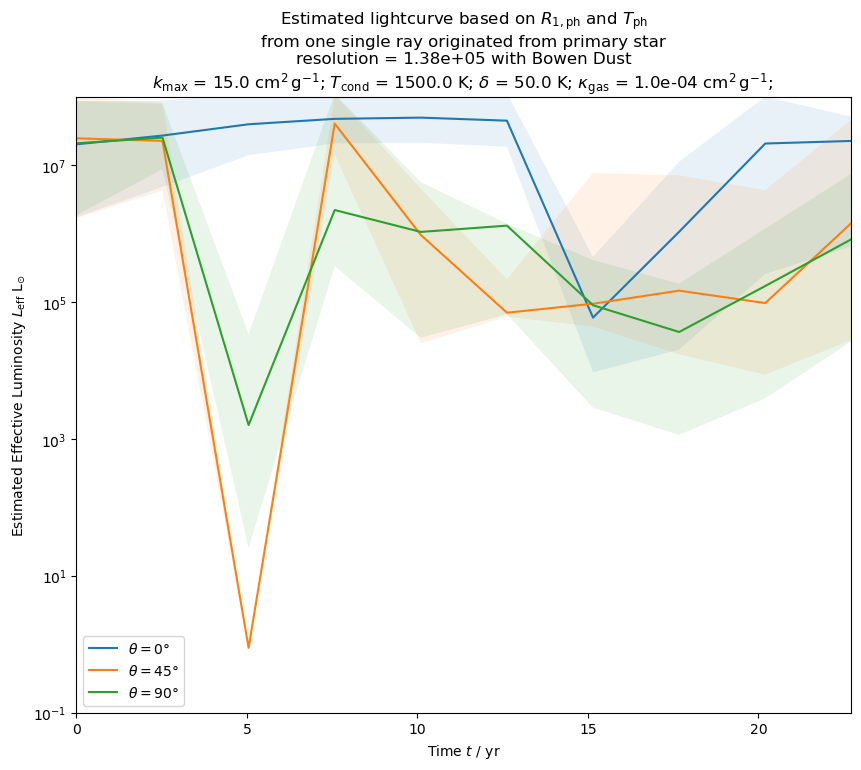

In [29]:
if __name__ == '__main__':
    
    job_name = "../../dustystar/test_miguel/bowendust_res-1e5/binary"
    ray_dir_vecs = np.array([
        [  0., 0., 100.],
        [100., 0., 100.],
        [100., 0.,   0.],
    ])
    ylim_Leff = (1e-1, 1e8)

    ylim = ylim_Leff
    fig, ax = plt.subplots(figsize=(10, 8))

    
    for ray_dir_vec in ray_dir_vecs:
        print(f"\n{ray_dir_vec = }\n")
        moviefilename, times, photospheres, lum_effs = plot_mpdf_movies_single_ray_trace_profiles__TMP_FUNC_IGNORE_ME(
            job_name=job_name,
            file_range=(0, 9000+1, 1000),
            plot_title_suffix=PLOT_TITLE_SUFFIX,
            ray_dir_vec=ray_dir_vec,
            use_idealgas_temperature = True,
            mu = 2.380981,    # mean molecular weight, used if use_idealgas_temperature
            photosphere_tau=1.,
        )
        obs_angle = np.arctan(np.array(ray_dir_vec[0]**2 + ray_dir_vec[1]**2)**0.5 / ray_dir_vec[2]) / pi * 180.
        ax.semilogy(times.value, lum_effs[:, 0].value, label=f"$ \\theta = {obs_angle:.0f} \\degree$")
        ax.fill_between( times.value, lum_effs[:, 1].value, lum_effs[:, 2].value, alpha=0.1)
        
    ax.set_xlim(times[[0, -1]].value)
    ax.set_ylim(ylim)
    ax.set_xlabel(f"Time $t$ / {times.unit.to_string('latex')}")
    ax.set_ylabel(f"Estimated Effective Luminosity " + \
                  f"$L_{{\\rm eff}}$ {lum_effs.unit.to_string('latex')}")
    ax.set_title(
        "Estimated lightcurve based on $R_{{1, \\rm ph}}$ and $T_{{\\rm ph}}$\n" + \
        f"from one single ray originated from primary star\n" + \
        f"resolution = {mpdf.params['nparttot']:.2e}{plot_title_suffix}",
    )
    ax.legend()
    
    outfilename = f"{job_name}__lc_Bowen-dust-opacity.png"
    fig.savefig(outfilename)

In [40]:
if __name__ == '__main__':
    ray_dir_vec = [  0., 0., 100.]
    print(f"\n{ray_dir_vec = }\n")
    moviefilename, times, photospheres, lum_effs = plot_mpdf_movies_single_ray_trace_profiles__TMP_FUNC_IGNORE_ME(
        job_name="../../photosphere/luis_4md/binary",
        file_range=(0, 2772+1, 396),
        plot_title_suffix=", 3.7Msun dusty",
        ray_dir_vec=ray_dir_vec,
        use_idealgas_temperature = False,
        mu = None,#2.380981,    # mean molecular weight, used if use_idealgas_temperature
        photosphere_tau=1.,
        fps=1,
    )


ray_dir_vec = [0.0, 0.0, 100.0]

    Note: Using ieos= 10 for temperature calc.


Working on: ../../photosphere/luis_4md/binary_00000

3911 particles are close enough to the ray to have effects.
ray = array([[-8.82159543e+01, -1.82796033e-03, -1.03191347e-03],
       [-8.82159543e+01, -1.82796033e-03,  9.99989681e+01]])

pts_order_nonzero.size = 3911

    Note: Using ieos= 10 for temperature calc.


Working on: ../../photosphere/luis_4md/binary_00396

4005 particles are close enough to the ray to have effects.
ray = array([[ 73.73404617, -47.14192758,  -0.44802678],
       [ 73.73404617, -47.14192758,  99.55197322]])

pts_order_nonzero.size = 4005

    Note: Using ieos= 10 for temperature calc.


Working on: ../../photosphere/luis_4md/binary_00792

4120 particles are close enough to the ray to have effects.
ray = array([[-44.38914696,  72.79156238,   0.14964304],
       [-44.38914696,  72.79156238, 100.14964304]])

pts_order_nonzero.size = 4120

    Note: Using ieos= 10 for temperatur

Moviepy - Done !
Moviepy - video ready ../../photosphere/luis_4md/binary__photosphere-tau+T+rho-profile__R1-x0.0y0.0z1.0__movie.mp4


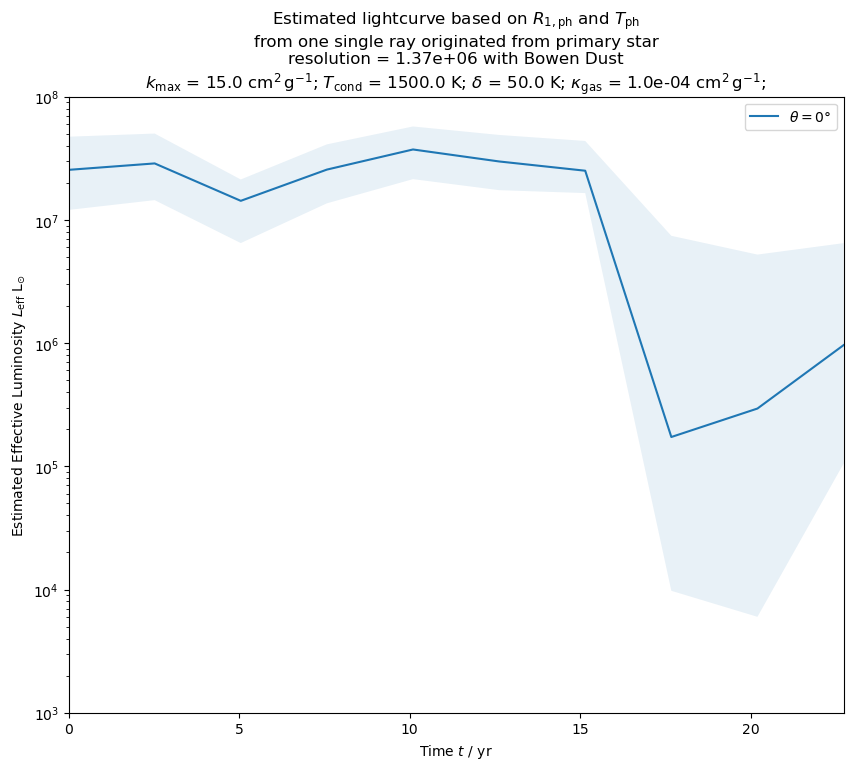

In [186]:
if __name__ == '__main__':
    ylim_Leff = (1e3, 1e8)

    ylim = ylim_Leff
    fig, ax = plt.subplots(figsize=(10, 8))

    obs_angle = np.arctan(np.array(ray_dir_vec[0]**2 + ray_dir_vec[1]**2)**0.5 / ray_dir_vec[2]) / pi * 180.
    ax.semilogy(times.value, lum_effs[:, 0].value, label=f"$ \\theta = {obs_angle:.0f} \\degree$")
    ax.set_xlim(times[[0, -1]].value)
    ax.set_ylim(ylim)
    ax.fill_between( times.value, lum_effs[:, 1].value, lum_effs[:, 2].value, alpha=0.1)
    ax.set_xlabel(f"Time $t$ / {times.unit.to_string('latex')}")
    ax.set_ylabel(f"Estimated Effective Luminosity " + \
                  f"$L_{{\\rm eff}}$ {lum_effs.unit.to_string('latex')}")
    ax.set_title(
        "Estimated lightcurve based on $R_{{1, \\rm ph}}$ and $T_{{\\rm ph}}$\n" + \
        f"from one single ray originated from primary star\n" + \
        f"resolution = {mpdf.params['nparttot']:.2e}{plot_title_suffix}",
    )
    ax.legend()

# checking ideal gas temperature profile
mu = 2.380981    # mean molecular weight
mpdf.read(
    JOB_NAME, 8000,
    calc_params=[], #
    reset_xyz_by_CoM=True,
)
sdf = mpdf.data['gas']
sdf_sink = mpdf.data['sink']
sdf['T'] = (2./3. * mu * (set_as_quantity(sdf['u'], unit=mpdf.units['specificEnergy']) ) / CONST_KB_ON_MH).cgs.value
sdf['R1'] = ((sdf['x'] - sdf_sink['x'][0])**2 + (sdf['y'] - sdf_sink['y'][0])**2 + (sdf['z'] - sdf_sink['z'][0])**2)**0.5
sdf[sdf['R1'] < 60]

xlim = (-1, 3)
ylim = (1, 7)

fig, ax = plt.subplots(figsize=(10, 8))

#ax.scatter(np.log10(sdf['R1']), np.log10(sdf['T1']))
ax.scatter(np.log10(sdf['R1']), np.log10(sdf['rho']))

ax.set_xlim(xlim)
ax.set_xlabel(f"$\\log_{{10}}r_1$  ($R_\\odot$)")
#ax.set_ylim(ylim)
#ax.set_ylabel(f"$\\log_{{10}}T$  (K)")